No. counties (covid df): 3195 
No. counties (county df): 3220 
No. counties (merged df): 3140 



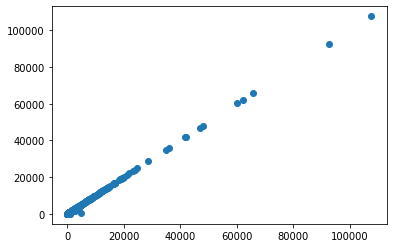

In [57]:
"""
DATA SOURCES:
https://usafacts.org/visualizations/coronavirus-covid-19-spread-map/
https://www.kaggle.com/muonneutrino/us-census-demographic-data?select=acs2015_county_data.csv

"""

import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler

data_dir=r'C:\Users\Cafral\Desktop\kaggle\team_ts_forecast\embeddings\data'

#loading the data

#county data
county_data = pd.read_csv(data_dir+r'\county_data\datasets_7001_312628_acs2015_county_data.csv')

#covid num cases data
covid_data = pd.read_csv(data_dir+r'\covid_data\covid_confirmed_usafacts.csv')
covid_data.drop(columns=['County Name','State','stateFIPS'],inplace=True)
covid_data['max_case_count']= covid_data[covid_data.columns[1:]].max(axis=1)

#cumulative reporting
plt.scatter(covid_data['max_case_count'],covid_data['7/5/20'])
plt.plot()

merged_data = pd.merge(county_data,covid_data[['countyFIPS','max_case_count']],left_on=['CensusId']
                       ,right_on=['countyFIPS'])
merged_data.drop(columns=['countyFIPS'],inplace=True)
merged_data.dropna(inplace=True)
merged_data['state_county'] = merged_data['State'] +" "+ merged_data['County']

#disparity in num of counties
print('No. counties (covid df):',covid_data.shape[0],'\n'
      'No. counties (county df):',county_data.shape[0],'\n'
      'No. counties (merged df):',merged_data.shape[0],'\n'
     )

#keeping only relevant data
relevant_cols = ['state_county','TotalPop', 'Men', 'Women', 'Hispanic',
       'White', 'Black', 'Native', 'Asian', 'Pacific',
       'Income', 'IncomeErr', 'IncomePerCap', 'IncomePerCapErr', 'Poverty',
       'ChildPoverty', 'Professional', 'Service', 'Office', 'Construction',
       'Production', 'Drive', 'Carpool', 'Transit', 'Walk', 'OtherTransp',
       'WorkAtHome', 'MeanCommute', 'Employed', 'PrivateWork', 'PublicWork',
       'SelfEmployed', 'FamilyWork', 'Unemployment']#could add state here too?
#len(relevant_cols)

target_var = ['max_case_count']

train_df =merged_data[relevant_cols+target_var]

# Data Processing

In [58]:
label_encoders = {}

cat_cols = ['state_county']
for cat_col in cat_cols:
        label_encoders[cat_col] = LabelEncoder()
        train_df[cat_col] = label_encoders[cat_col].fit_transform(train_df[cat_col])

C:\Users\Cafral\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# Model

In [16]:
"""
based on:
https://yashuseth.blog/2018/07/22/pytorch-neural-network-for-tabular-data-with-categorical-embeddings/
"""

class TabularDataset(Dataset):
  def __init__(self, data, cat_cols=None, output_col=None):
    """
    Characterizes a Dataset for PyTorch

    Parameters
    ----------

    data: pandas data frame
      The data frame object for the input data. It must
      contain all the continuous, categorical and the
      output columns to be used.

    cat_cols: List of strings
      The names of the categorical columns in the data.
      These columns will be passed through the embedding
      layers in the model. These columns must be
      label encoded beforehand. 

    output_col: string
      The name of the output variable column in the data
      provided.
    """

    self.n = data.shape[0]

    if output_col:
      self.y = data[output_col].astype(np.float32).values.reshape(-1, 1)
    else:
      self.y =  np.zeros((self.n, 1))

    self.cat_cols = cat_cols if cat_cols else []
    self.cont_cols = [col for col in data.columns
                      if col not in self.cat_cols + [output_col]]

    if self.cont_cols:
      self.cont_X = data[self.cont_cols].astype(np.float32).values
    else:
      self.cont_X = np.zeros((self.n, 1))

    if self.cat_cols:
      self.cat_X = data[cat_cols].astype(np.int64).values
    else:
      self.cat_X =  np.zeros((self.n, 1))

  def __len__(self):
    """
    Denotes the total number of samples.
    """
    return self.n

  def __getitem__(self, idx):
    """
    Generates one sample of data.
    """
    return [self.y[idx], self.cont_X[idx], self.cat_X[idx]]

class FeedForwardNN(nn.Module):

  def __init__(self, emb_dims, no_of_cont, lin_layer_sizes,
               output_size, emb_dropout, lin_layer_dropouts):

    """
    Parameters
    ----------

    emb_dims: List of two element tuples
      This list will contain a two element tuple for each
      categorical feature. The first element of a tuple will
      denote the number of unique values of the categorical
      feature. The second element will denote the embedding
      dimension to be used for that feature.

    no_of_cont: Integer
      The number of continuous features in the data.

    lin_layer_sizes: List of integers.
      The size of each linear layer. The length will be equal
      to the total number
      of linear layers in the network.

    output_size: Integer
      The size of the final output.

    emb_dropout: Float
      The dropout to be used after the embedding layers.

    lin_layer_dropouts: List of floats
      The dropouts to be used after each linear layer.
    """

    super().__init__()

    # Embedding layers
    self.emb_layers = nn.ModuleList([nn.Embedding(x, y)
                                     for x, y in emb_dims])

    no_of_embs = sum([y for x, y in emb_dims])
    self.no_of_embs = no_of_embs
    self.no_of_cont = no_of_cont

    # Linear Layers
    first_lin_layer = nn.Linear(self.no_of_embs + self.no_of_cont,
                                lin_layer_sizes[0])

    self.lin_layers =\
     nn.ModuleList([first_lin_layer] +\
          [nn.Linear(lin_layer_sizes[i], lin_layer_sizes[i + 1])
           for i in range(len(lin_layer_sizes) - 1)])
    
    for lin_layer in self.lin_layers:
      nn.init.kaiming_normal_(lin_layer.weight.data)

    # Output Layer
    self.output_layer = nn.Linear(lin_layer_sizes[-1],
                                  output_size)
    nn.init.kaiming_normal_(self.output_layer.weight.data)

    # Batch Norm Layers
    self.first_bn_layer = nn.BatchNorm1d(self.no_of_cont)
    self.bn_layers = nn.ModuleList([nn.BatchNorm1d(size)
                                    for size in lin_layer_sizes])

    # Dropout Layers
    self.emb_dropout_layer = nn.Dropout(emb_dropout)
    self.droput_layers = nn.ModuleList([nn.Dropout(size)
                                  for size in lin_layer_dropouts])

  def forward(self, cont_data, cat_data):

    if self.no_of_embs != 0:
      x = [emb_layer(cat_data[:, i])
           for i,emb_layer in enumerate(self.emb_layers)]
      x = torch.cat(x, 1)
      x = self.emb_dropout_layer(x)

    if self.no_of_cont != 0:
      normalized_cont_data = self.first_bn_layer(cont_data)

      if self.no_of_embs != 0:
        x = torch.cat([x, normalized_cont_data], 1) 
      else:
        x = normalized_cont_data

    for lin_layer, dropout_layer, bn_layer in\
        zip(self.lin_layers, self.droput_layers, self.bn_layers):
      
      x = F.relu(lin_layer(x))
      x = bn_layer(x)
      x = dropout_layer(x)

    x = self.output_layer(x)

    return x

In [17]:
dataset = TabularDataset(data=train_df, cat_cols=cat_cols,
                             output_col=target_var)

batchsize = 10
dataloader = DataLoader(dataset, batchsize, shuffle=True,)

cat_dims = [int(train_df[col].nunique()) for col in cat_cols]
emb_dims = [(x, min(50, (x + 1) // 2)) for x in cat_dims]

model = FeedForwardNN(emb_dims, no_of_cont=len(relevant_cols), lin_layer_sizes=[50, 100],
                          output_size=1, emb_dropout= 0,#0.01,#0.04,
                          lin_layer_dropouts=[0.001,0.01])

#training the model
torch.manual_seed(0)
np.random.seed(0)

no_of_epochs = 200
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(no_of_epochs):
    for y,cont_x, cat_x in dataloader:
        
        # Forward Pass
        preds = model(cont_x, cat_x)
        loss = criterion(preds, y)
        

        # Backward Pass and Optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        loss_item = loss.item() / len(train_df) 
        print(loss_item)
    # display the epoch training loss
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, no_of_epochs, loss_item)) 


        

846.4773089171974
129.75381170382167
2435.271337579618
8875.441401273885
29.380252289012738
74.53907742834394
5938.475159235669
5025.398726114649
1059.8579617834396
225.74056528662422
4.828287656747611
5727.709554140128
150.1488256369427
101.87577627388535
124.49113256369426
53.86062898089172
142.7294287420382
15808.708280254777
260.66425159235666
651.4968949044586
42.031021098726114
19.150292346735668
350.02265127388534
151.85853901273885
11097.226751592356
88.83170780254777
8952.282165605095
246.4560907643312
184.6358877388535
6460.982802547771
743.0328821656051
24.276990445859873
1528.9458598726114
42433.210191082806
83.34193371815287
1812.0388535031848
42.43776871019108
3.946322029259554
83.41738156847134
11806.750318471337
66.9905951433121
13.009664858678343
5826.003184713376
906.2531050955414
4392.150318471337
843.7652070063695
128.35217953821655
5098.895859872611
11201.79872611465
728.3482484076433
70015.08789808917
539.2561305732484
18.51801602308917
279.55079617834394
26139.79

293.3176353503185
329.87882165605095
71.03293192675159
44.95930035828025
6911.420382165605
86.44118232484077
16.15355170183121
346.09554140127386
220.00895700636943
6331.147770700637
219.79576035031846
87.03697253184713
78.09244625796178
8918.394904458599
166.47051154458597
46360.810191082805
268.5357285031847
21.524586982484077
371.7283439490446
92.89282444267516
356.562300955414
290.4911823248408
582.2035828025478
40.519678045382165
3387.9194267515923
14.571281598328026
24.32121815286624
14.7111328125
175.84621815286624
715.9710987261146
121.92947850318471
9.08132153164809
26.023964968152868
447.10505573248406
6751.784076433121
474.6860270700637
34.917821954617835
171.14470541401275
250.49335191082804
117.5234275477707
245.2968152866242
371.32921974522293
257.1238256369427
63.42592555732484
30.907352209394904
60020.71847133758
217.4452826433121
348.51791401273886
31.851144506369426
324.18491242038215
494.5841560509554
93.66202229299363
227.0013535031847
19837.96942675159
107.94934315

151.07542794585987
2529.769904458599
269.7597133757962
6217.08152866242
377.4934315286624
371.4684713375796
174.78485270700637
326.1442277070064
387.88960987261146
2880.0168789808918
126.63315087579618
5372.673248407643
306.7974522292994
194.81005175159237
221.38803742038218
399.3976114649682
1571.7452229299363
427.2023487261146
148.3252089968153
368.9988455414013
1858.697770700637
349.80999203821654
78.90960390127388
43598.84840764331
1325.3175955414013
443.0533837579618
9568.522929936305
1064.0794585987262
2572.8194267515923
191.68525079617834
83.66910828025478
36.050084593949045
1771.4093949044586
11772.822929936307
164.7624203821656
421.4464171974522
56.711892914012736
epoch : 3/200, loss = 56.711893
33.75805632961784
11768.970700636943
115.80430931528663
41.719673069267515
1503.799203821656
43.34422273089172
385.48371815286623
339.01035031847135
42.75438395700637
77.3702229299363
217.36681926751592
108.47375597133758
81.6358777866242
2012.1328025477708
539.1593550955414
478.622929

229.51017117834394
670.292117834395
111699.1898089172
51.88940087579618
31.031857085987262
954.2426751592357
2751.3914012738855
380.0453821656051
195.9658837579618
433.71122611464966
315.4051950636943
431.2878184713376
9682.311464968152
409.79621815286623
37938.75668789809
467.15855891719747
430.51759554140125
49.23453921178344
511.9908837579618
463.17300955414015
4260.972611464968
471.40358280254776
553.2310111464968
452.46616242038215
422.9752388535032
628.8385350318472
50.894650676751596
578.5709394904459
55.52098427547771
221.89478503184714
5582.8121019108285
631.4498805732484
940.5874203821656
1084.2039808917198
101.2673467356688
578.571775477707
253.5075636942675
116.71589371019108
779.8091560509554
283.2533041401274
52.399442675159236
691.4341560509554
406.32205414012736
286.82097929936305
50.49680533439491
587.1698646496816
240.9689888535032
177.41988455414014
341.893152866242
377.1690286624204
2564.4891719745224
1553.7520700636942
543.5348328025477
297.1546178343949
1527.09187

761.5231687898089
24285.329936305734
19239.256050955413
289.15360270700637
1114.3638535031846
608.6190286624204
323.6122213375796
700.6289012738854
15.44964047571656
153.49522292993632
1343.0638535031846
480.12261146496814
134.88835589171975
1354.9538216560509
6746.62101910828
968.5674363057325
210.66516719745223
1259.9781050955414
244.19430732484076
52.16795382165605
334.75238853503186
137.42011345541403
277.37430334394907
839.7164808917197
680.7278662420382
3059.038853503185
2062.5918789808916
554.8182324840765
961.9611464968153
3388.8426751592356
384.7015127388535
147.69802945859874
417.8408041401274
623.2596337579618
63.702318869426755
976.6428343949044
492.19916401273883
329.42123805732484
160.66614251592355
174.228224522293
285.2378383757962
349.6382961783439
977.5404458598726
211.7528662420382
126.03406648089172
73.59232683121019
188.09635748407644
122.55651871019109
888.3316878980892
557.6544585987261
296.422074044586
326.04888535031847
204.2826632165605
5693.568789808917
2490.

322.0640724522293
293.14892515923566
181.26476910828026
513.2671576433121
780.0892515923567
157.8513734076433
381.4658439490446
160.7986166401274
327.1920780254777
280.0573646496815
91.07549761146497
1096.4326433121018
4487.930573248407
667.8006369426752
389.3235668789809
5155.492993630573
78.3750696656051
1031.4332802547772
1119.4285031847135
265.7236066878981
4410.184394904459
194.1890525477707
274.9012340764331
299.7448447452229
153.0767515923567
256.84506369426754
66.1422671178344
143.89174960191082
102.2405553343949
437.0620222929936
668.5985668789809
11051.450955414013
191.97547770700638
258.42573646496817
2256.8611464968153
313.4437300955414
67.15738953025478
1925.5328025477706
87.14610867834395
280.2935111464968
147.88361863057324
2406.283280254777
2476.9799363057323
149.1594247611465
266.4941679936306
190.33988853503186
175.4890525477707
200.65545382165604
650.7494824840765
249.10429936305732
866.4329617834395
114.69425756369426
78.15265226910827
196.4326035031847
303606.66496

77.76167396496815
795.1408439490446
290.3128582802548
353.7201433121019
165.50191082802547
138.01968550955414
281.39414808917195
1905.2063694267515
134.01321656050956
200.9470143312102
881.1113057324841
297.7755374203822
540.4486066878981
191.64826831210192
328.3095939490446
240.128125
244.2529060509554
155.84148089171975
572.3127388535032
131.5721138535032
615.557643312102
104.0076930732484
361.26624203821655
278.9484474522293
140.586037022293
321.78642515923565
142.84111265923568
170.39261544585986
77.05013435509554
191.4875398089172
326.44150079617833
814.0281847133758
90.99745222929937
352.91775477707006
263.975
474.14785031847134
16487.03949044586
162.61363455414013
451.36174363057324
239.52730891719744
281.16687898089174
896.5350318471337
138.33022492038216
321.79751194267516
2739.7824840764333
411.26297770700637
80.46296277866242
38253.79872611465
75.61268909235669
239.77671178343948
121.31856090764332
258.0863654458599
1123.0458598726116
186.59171974522292
213.7528662420382
321

222.26954617834394
182.58184713375798
147.11789410828027
185.5498407643312
284.94337181528664
446.56616242038217
247.29291401273886
95.97638335987261
240.60483678343948
321.902925955414
203.80505573248408
87.34162022292993
200.5170979299363
174.4906449044586
347.7266321656051
1022.6997611464968
116.41459992038216
329.1200636942675
242.00127388535032
194.8564092356688
115.14621815286624
354.68829617834393
1100.252229299363
297.42388535031847
194310.0331210191
303.6045581210191
194.41875
395.53558917197455
172.17559713375798
253.77543789808917
258.7421576433121
240.3545581210191
335.9751592356688
556.3179140127388
319.0613455414013
202.96962579617835
431.487699044586
341.8820859872611
62.86194765127389
472.77420382165604
310.0439888535032
481.309275477707
114.68724124203821
123.81573447452229
702.1036624203822
100.90059713375796
258.7606090764331
187.63507165605097
183.9548367834395
257.6876791401274
125.72541799363057
227.437699044586
795.0549363057324
228.32615445859872
83776.382165605

296.9218550955414
1693.341560509554
274.5403463375796
298.38300159235666
261.89375
156.4359872611465
123.56122611464968
548.4117834394905
337.5612659235669
191.94558121019108
208.70238853503184
111.59083399681529
1398.0265923566878
120.734375
275.35513535031845
67.80728503184713
258.34775079617833
89.44900477707006
774.6207802547771
776.9388535031848
341.10565286624205
184669.04458598726
128.05726512738855
227.13489251592355
153.25439888535033
111.0578025477707
271.37271098726114
97.462400477707
297.3319068471338
690.8503184713376
151.7874701433121
575.6801353503184
348.2924363057325
119.56116640127388
222.63546974522293
935.9549363057325
581.2634554140127
153.69007762738855
211.7640923566879
106.14830812101911
256.80991242038215
391.2345939490446
91.68607683121019
359.33037420382163
2767.998407643312
151.62932921974522
406.1405652866242
187.59144108280256
351.3769506369427
86.73641520700637
951.7311305732484
313.309175955414
318.7235668789809
60.90437898089172
59.75573248407643
106.27

268.3236664012739
202.21691878980891
153.2140127388535
813.9514331210191
249.8908041401274
192.87113853503186
147.2747910031847
228.99006767515922
149.70552348726116
486.7081608280255
1563.4614649681528
144.74174960191084
140.10799164012738
585.3958598726115
179.92553742038217
171.06309713375796
456.3482085987261
227.40041799363058
350.80031847133756
169.14201831210192
334.07603503184714
epoch : 13/200, loss = 334.076035
130.59138136942676
136.6345541401274
220.83544984076434
342.5139729299363
360.7637738853503
291.4531449044586
249.859275477707
195.4780055732484
131.7779956210191
16902.51719745223
696.583280254777
823.8407643312102
280.65513535031846
272.7732085987261
1370.9245222929937
110.82377587579617
74.01041998407644
49.99079418789809
632.7959394904459
250.1673964968153
169.86039012738854
848.6218152866242
152.22076035031847
107.64479498407643
128.53017515923568
271.1921576433121
74.93249900477707
86.54278463375796
303.9308320063694
147.13970939490446
294.8827428343949
286.80185

133.45394108280254
220.37265127388534
481.66632165605097
435.6359076433121
197.31787420382165
475.3344347133758
98.84510350318472
2447.1503184713374
41.82552249203822
145.89973128980893
216.021775477707
145.9017217356688
248.41480891719746
2253.6170382165606
39.3038664410828
340.82157643312104
330.7297173566879
161.24978105095542
39.06931976512739
372.4252786624204
220.437699044586
273.97410429936303
379.5390923566879
587.4349124203821
859.7040605095541
188.18387738853502
231.5702229299363
248.4266321656051
111.95691679936306
422.7068073248408
201.68035429936305
204.05437898089173
170.26759554140128
302.7499601910828
1202.8942675159235
281.3247213375796
147.18776871019108
267.340724522293
280.16142515923565
1510.4216560509553
135.4842356687898
187.57714968152865
169.57776671974523
82.54415804140127
60.34549661624204
127.33790804140128
158.49647691082802
99.50998208598726
571.2885350318471
2159.7141719745223
215.52870222929937
164.65439888535033
179.62716958598728
973.0822452229299
53.5

121.87381568471338
639.3585987261147
928.0209394904458
283.9815286624204
180.4405055732484
401.4497611464968
148.79864649681528
148.75074641719746
499.9428343949045
1185.8289012738853
321.59146098726114
2718.892356687898
1602.5759554140127
296.1827428343949
1487.1958598726114
303.1015525477707
1038.9122611464968
200.2094347133758
137.15066679936305
1198.6214968152867
958.6546178343949
1252.3551751592356
146.65414012738853
177.52133757961784
210.9033439490446
292.078622611465
842.7953821656051
66.20205015923567
334.33698248407643
251.88409633757962
69.43995820063694
273.68162818471336
84.78608678343949
3311.502547770701
354.8032643312102
107.6249800955414
127.22466162420382
283.4814689490446
337.51293789808915
141.73349920382165
175.95712579617833
40.89420780254777
312.22064092356686
189.9939888535032
301.09920382165603
870.348805732484
11.581696606289809
1101.6424363057324
112.84638734076434
291.7076035031847
135.12738853503186
219.1294785031847
183.43427547770702
183.8983081210191
541

487.80517515923566
574.03224522293
365.609076433121
358.2371815286624
68.39886046974522
362.6027070063694
391.2048566878981
1014.246576433121
188.4063893312102
285.36620222929935
55.99672074044586
274.199800955414
305.0187300955414
337.5440286624204
1257.7406050955415
213.4202428343949
498.82312898089174
1116.2696656050955
822.1732484076433
66.03857484076433
319.50376194267517
289.63837579617837
150.8579617834395
265.67551751592356
591.9688694267516
194.53957006369427
167.99273487261146
62.31425159235669
289.1349124203822
656.2099920382166
99.69692476114649
845.4382165605095
241.65855891719744
88.33284235668789
49256.937579617836
331.7846138535032
456.0248407643312
803.3123407643312
250.61857085987262
42.59186902866242
97.48841560509554
1889.681050955414
198.3015923566879
809.5097133757962
134.00188097133758
504.8987659235669
115.28875398089173
127.76587380573248
344.13252388535034
62.74871616242038
3247.8213375796176
92.5673765923567
125.08084195859873
393.6158837579618
261.0011544585

1493.1996815286625
560.172173566879
622.5017117834395
232.96490843949044
728.0952229299363
273.2440684713376
1317.0017515923566
313.80887738853505
1183.1049363057325
890.3377388535032
170.58897292993632
163.7937699044586
144.6660031847134
68.88106588375796
288.44621815286627
354.83109076433124
1064.916719745223
123.07629378980891
224.05891719745222
118.71324641719745
885.003025477707
209.85897691082803
115.44459593949044
1212.78025477707
320.66341560509557
347.684474522293
83.7343550955414
131.7925557324841
380.5888136942675
176.13258359872611
130.60718550955414
475.3673566878981
5313.920063694268
165.4577428343949
65.22646795382165
111.66829219745223
602.4478901273885
271.62569665605093
2181.9665605095543
622.4306926751592
182.84076433121018
142.68214570063694
121.73649482484076
244.8436106687898
402.2121815286624
155.39461584394905
98.51172372611465
2714.226751592357
250.05115445859872
236.47778662420382
998.4131369426751
287.60913614649684
257.96474920382167
148.98778861464967
349.4

117.98497213375796
265.6830015923567
321.8889132165605
445.55680732484075
233.6530453821656
89.48834593949044
131.67418391719744
252.74566082802548
264.7125398089172
70.7421974522293
1272.8097133757963
79.42921974522292
71.4968252388535
1730.190923566879
454.64589968152865
142.04092356687897
203.7968550955414
151.91025079617833
308.6172571656051
483.83797770700636
120.87486066878981
526.4023487261146
222.15203025477706
1114.2176751592356
1387.2523885350317
121.00539410828026
2075.8398089171974
340.5825636942675
185.68063296178343
503.0000796178344
279.46596337579615
281.67308917197454
436.31015127388537
180.96449044585987
349.76345541401275
339.0262340764331
68.08660927547771
253.73148885350318
214.4950437898089
181.35529458598725
268.91968550955414
388.44657643312104
366.28877388535034
271.3660429936306
150.64127189490446
178.2063893312102
124.98107085987262
118.40810111464968
1505.137898089172
430.42587579617833
97.18533041401274
399.59781050955417
346.63813694267515
87.3276970541401

95.26305732484076
136.07426353503186
114.31000199044585
1954.801592356688
42.22678144904459
120.43331011146496
89.50124402866243
207.95696656050956
121.42217356687898
180.34462579617835
99.33230493630573
137.01900875796179
184.40738455414012
199.4080015923567
109.59565087579618
196.83829617834394
349.5372611464968
134.5356687898089
3524.004458598726
65.67151671974523
2562.3078025477707
108.24415804140128
116.93214570063694
155.95557324840763
1095.9555732484077
121.71189291401274
80.87909036624204
127.65196058917198
184.85583200636944
69.14514331210191
123.29915406050955
192.60991242038216
66.14793491242038
92.16034036624204
86.00191082802547
126826.47643312102
221.86168391719744
71.6157344745223
98.62075039808917
252.59442675159235
82.78642515923566
357.09904458598726
280.15107484076435
176.02712977707006
62.266281847133754
115.10886743630573
198.68785828025477
62.31437101910828
90.18129976114649
822.8862261146497
197.1263535031847
444.13873407643314
122.79554140127388
107.312908041401

141.5328324044586
182.9481687898089
191.64942277070062
198.7908638535032
82.58710191082803
471.8360668789809
201.72882165605097
151.73181727707006
249.3107085987261
192970.8840764331
279.7996815286624
548.87400477707
238.5199442675159
594.1505573248407
1399.5207006369426
469.443351910828
208.19663614649681
127.0437599522293
181.67386544585986
200.2578423566879
219.67898089171973
97.07234275477707
332.9357882165605
1632.8
118.25830015923567
epoch : 23/200, loss = 118.258300
176826.0076433121
249.37910031847133
124.82791600318471
83.1702925955414
358.98479299363055
478.38224522292995
201.89305334394905
175.15871815286624
103.62350716560509
178.5608678343949
272.90250796178344
5292.292993630574
148.29326234076433
99.26465963375796
310.6657046178344
381.91214171974525
570.0538216560509
167.07257165605097
157.51444068471338
172.3939092356688
145.15592157643312
928.9964968152866
211.2720143312102
671.2839171974522
228.4609275477707
351.7588375796178
46.72249701433121
81.6623905254777
177.450

385.57914012738854
300.84924363057326
751.3273089171975
22631.96942675159
349.15756369426754
580.5650477707006
764.0394904458599
697.2500796178344
550.0024283439491
311.2499601910828
304.17902070063695
237.09112261146498
1036.8789012738853
143.53767914012738
47.930334394904456
144.79146098726116
532.5797770700636
3949.4761146496817
335.7218550955414
136.81765525477707
93.52934912420382
145.35530453821656
217.5343351910828
160.06447054140128
262.42687101910826
155.4737460191083
889.4549363057325
230.59104299363057
257.99645700636944
858.2950636942675
391.54275477707006
806.7946656050956
163.35965366242038
114.77170581210191
128.67558718152867
1709.6514331210192
289.30700636942674
327.4607882165605
63.7859574044586
156.3312898089172
230.80336385350319
158.56764530254776
222.80081608280256
369.89375
163.49009753184714
1194.6320063694268
53.832469148089174
381.0542595541401
83.88201632165605
290.9747810509554
66.50176652070064
155.61124601910828
86.52267117834396
161.75974323248408
122.678

2509.007643312102
186.80103503184714
220.97018312101912
261.15529458598724
35.798081707802545
558.7011544585987
175.67945859872611
133.20254777070065
70.7781946656051
67.44132165605096
3001.625159235669
253.79319267515925
84.17628383757962
62.00653363853503
59.85341361464968
233.05891719745222
203.30421974522292
299.959076433121
407.9298566878981
266.1761345541401
117.95565286624203
218.3469347133758
259.2513335987261
165.9544785031847
156.73619625796178
141.201861066879
52.97829916401274
81.53649482484076
147.73977906050956
348.5184315286624
240.83077229299363
673.2281847133758
21053.852229299362
90.71029060509554
208.18234474522293
176.8548964968153
101.88314092356688
101.24810907643312
196.2891918789809
207.52854299363057
4464.269426751593
637.3037022292993
251.29504378980891
154.11523686305733
298.5517914012739
247.36685907643312
233.79603901273885
296.49597929936306
78.70566281847134
122.51297770700637
242.39643710191083
136.4967953821656
100.94753184713376
107.83115047770701
253.

373.81982484076434
433.9293391719745
274.18385748407644
279.3010549363057
210.37125796178344
201.86309713375798
113.65667794585987
181.60433917197452
385.45043789808915
306.5591162420382
191.65903662420382
44.05389132165605
128.2780055732484
216.95648885350317
287.02605493630574
3694.207643312102
2654.837898089172
285.7982484076433
278.87133757961783
400.6700238853503
186.44438694267515
200.18630573248407
268.34591958598725
286.59458598726115
343.0531050955414
313.6198447452229
294.74745222929937
678.3529458598726
1732.68949044586
466.95975318471335
252.32878184713377
242.7033638535032
323.1035429936306
166.607912022293
450.32416401273883
286.91299761146496
272.25983280254775
251.81532643312102
356.97850318471336
706.1162420382166
350.53411624203824
275.08837579617835
367.1889331210191
97.33023487261147
358.43347929936306
168.82137738853504
205.478025477707
277.22255175159233
138.11361464968152
165.993650477707
37.103794287420385
162.75366242038217
316.72792595541404
460.5558917197452


134.27852308917198
83.30886743630573
118.13962977707007
68.01088276273886
79.94039609872611
477.5644108280255
112.75017914012739
59.10387141719745
164.2157344745223
176.87424363057326
62.115983280254774
151.3074542197452
98.86892914012739
94.7906648089172
122.11303742038217
200.29154060509555
112.13454418789809
216.32010350318473
18001.24585987261
387.65358280254776
184.31500796178344
183.1982683121019
107.88341958598726
1341.0477707006369
6270.6815286624205
718.5515923566879
141.60826035031846
101.27889132165605
173.39122213375796
58.01578423566879
153.88372810509554
211.40447850318472
35.429498407643315
402.5162022292994
212.17641321656052
72.39682523885351
90.64484474522293
128.06670979299363
171.4109275477707
141.8861464968153
281.1478105095541
202.96146496815285
148.6437400477707
1864.3700636942676
119.25459792993631
268.64309315286624
149.67709992038218
210.15895700636943
546.8510748407643
281.1823845541401
125.08255374203821
69.72809016719745
198.21289808917197
293.2746218152866

208.89498407643313
306.5107882165605
101.62611464968153
199.8468152866242
539.2406449044586
5508.062420382165
22674.078980891718
1136.5345541401273
262.1119824840764
63.97624402866242
124.75844944267516
318.2178742038217
200.1920780254777
14185.724840764331
253.35672770700637
364.0638933121019
95.70681727707006
315.1199442675159
210.4720939490446
335.0778662420382
336.2101114649682
201.95121417197453
1389.5880573248407
165.44286425159237
434.0027468152866
189.12543789808916
184.59124203821656
99.6656050955414
312.4723328025478
92.58843550955415
7438.301910828025
10397.708280254777
120.76443073248407
512.4853901273885
291.8948049363057
662.6373407643312
402.8564888535032
266.7983678343949
317.32681130573246
358.01508757961784
344.10437898089174
440.78984872611466
305.2888535031847
240.30656847133758
202.69653662420382
377.497372611465
3638.8866242038216
466.5296178343949
340.1607085987261
324.37796576433124
131.37445262738854
321.59478503184715
216.77115843949045
5052.875477707006
324.1

227.0763933121019
159.52561703821655
163.3418590764331
482.12874203821656
272.8949044585987
205.1874203821656
426.3390525477707
36.98894058519108
96.84536226114649
285.60254777070065
187.6844347133758
837.0975318471337
92.86044984076433
221.60210987261146
366.69120222929934
68.73426054936306
595.3085191082803
798.7023885350319
160.02083996815287
218.62758757961782
156.70037818471337
102.95965366242038
142.37151671974522
204.81650079617833
1472.5576433121018
223.07398487261148
200.71620222929937
304.2752189490446
129.90981289808917
342.5047770700637
115.60645899681529
144.77221337579618
195.61906847133758
281.5989848726115
1047.334872611465
200.83310111464968
339.4409633757962
160.6846835191083
202.5108280254777
161.6282145700637
602.8843949044586
104.71697850318472
240.90232882165606
109.78844546178344
103.18484275477707
187.7609673566879
377.87221337579615
127.4392217356688
280.16470939490443
356.21815286624206
191.49291401273885
340.26476910828023
195.28178742038216
165.7445660828025

313.9814888535032
268.40668789808916
107.74309315286624
207.30993232484076
888.1864649681529
408.91377388535034
1038.5744426751592
305.94502388535034
229.59130175159237
271.844148089172
86.43819665605096
276.27563694267513
160.1720541401274
16287.192356687898
279.1784434713376
570.358280254777
555.2297372611465
124.5389828821656
102.05719546178344
epoch : 33/200, loss = 102.057195
74.23266819267516
482.6202229299363
76.40611564490446
163.75515525477707
549.9858678343949
1977.4692675159235
645.2548964968153
265.28341958598725
206.37143710191083
130.3686604299363
260.92105891719746
398.94307324840764
233.85977308917197
555.1812898089172
425.3599522292994
206.99056528662422
344.9714968152866
1516.6684713375796
6064.3292993630575
90.61542595541401
228.45595143312102
787.6730095541401
430.3796974522293
524.2008359872611
391.3607484076433
56.19728801751592
186.2919187898089
227.99285429936305
631.4696656050955
621.8093550955414
1858.1926751592357
240.293949044586
246.82127786624204
5687.6878

119.02538813694268
639.8669984076433
1910.2457006369427
252.07446257961783
246.69796974522293
440.16039012738855
39.11862559713376
65.97102906050955
231.0217356687898
162.4642217356688
222.02939888535033
241.2627587579618
404.5796974522293
87.91028065286625
143.96289808917197
200.09560111464967
311.8730493630573
27.368565883757963
59.18656449044586
439.85230891719743
209.3466162420382
1213.1337579617834
294.64792993630573
5742.929936305733
958.537898089172
35.596350019904456
228.41134554140126
123.98353901273886
87.66948646496816
222.49466560509555
221.87294984076433
46.450840963375796
129.75693670382165
50.52388037420382
126.42108877388534
261.6124601910828
13180.383439490446
262.7959992038217
47.9577726910828
136.60539410828025
196.41347531847134
196.6076831210191
137.46009156050957
165.1998407643312
203.82850318471338
60.6140923566879
299.6828622611465
869.6281050955414
169.61076831210192
122.03007563694267
233.17273089171974
67.61244526273886
4058.3471337579617
346.6564092356688
99

1380.3041401273886
517.9722929936306
234.35527468152867
182.93821656050955
183.85203025477708
253.218650477707
232.36381369426752
92.5546078821656
9099.057324840764
178.75774283439492
395.63025477707004
1050.8167197452228
140.72712977707008
58.20928542993631
244.05553343949043
1175.2778662420383
230.1266122611465
219.49454617834394
433.12921974522294
182.96114649681527
501.13037420382165
298.2190087579618
184.5611863057325
205.6766122611465
492.0546974522293
318.76518710191084
283.40949442675156
301.20388136942677
85.13694267515923
155.929886544586
106.43695262738854
140.71640127388534
170.13459394904459
361.79498407643314
267.8593949044586
197.59745222929936
369.0177547770701
214.49791003184714
172.13849522292995
159.67394506369428
254.7923168789809
113.30178144904458
246.34749203821656
169.5578224522293
172.89757165605096
295.6609872611465
97.53979896496816
245.43045382165604
2643.5957006369426
133.87579617834396
205.62422372611465
16102.112101910829
1888.9630573248407
268.1495621019

111.88798765923566
848.465127388535
518.369347133758
64.80238853503185
98969.2025477707
295.89749203821657
73.15398089171974
40.14033140923567
231.1733877388535
340.70366242038216
417.58527070063695
109.35507563694267
250.73570859872612
138.69598925159235
454.94777070063697
179.87794585987263
75.55673765923567
286.80121417197455
188.1000398089172
7854.130573248408
90.17271098726114
4423.099044585987
187.64615843949045
261.4930135350318
451.45851910828026
1450.925796178344
213.84460589171974
299.71644108280253
202.5983479299363
201.92762738853503
261.5687898089172
206.90736464968154
256.5012340764331
217.41078821656052
222.41825238853502
192.36745621019108
154.78015525477707
235.32762738853503
178.75439888535033
8206.566878980891
2363.956210191083
381.60847929936307
262.056449044586
104.50517515923566
118.33808718152866
820.6113057324841
82.60522989649681
266.98521098726115
158.32746815286623
241.81795382165606
245.18531050955414
276.0894506369427
532.2566878980891
237.03395700636943
24

236.60507563694267
148.27088972929937
351.4050557324841
113.86791401273885
92.95273686305732
123.8953523089172
111.64237659235668
43.646521695859875
119.24057523885351
1029.396178343949
102.0374303343949
147.27716958598725
65.1591859076433
106.89699442675159
69.52785131369427
44.692928941082805
9540.931210191084
196.72945859872613
142.92232285031847
37.316003184713374
1052.2221337579617
230.25708598726115
93.65455812101911
109.83473328025478
135.27195461783438
152.54445660828026
92.76690883757962
239.5441082802548
36.87784136146497
125.00535429936306
298.30187101910826
304.3216162420382
222.0327030254777
1164.6826433121018
207.72935907643313
114.88529060509555
1032.917515923567
165.2765425955414
175.06492834394905
130.96312699044586
90.62113853503185
31.583260350318472
129.3000696656051
67.29365545382166
169.49771098726114
36.85593650477707
883.7282643312102
216.32384554140128
70.8422472133758
7473.068789808917
223.9643312101911
240.05704617834394
74.34887042197452
171.49442675159236
1

171.25704617834396
174.9111066878981
713.9357484076434
106.23017515923567
679.181847133758
97.23323049363057
31.08363853503185
231.36640127388534
380.01054936305735
194.4002786624204
46.523357882165605
409.81811305732487
192.19327229299364
6417.964331210191
5681.866878980892
28.843289709394906
10304.173248407644
152.30504578025477
373.81759554140126
117.50183121019109
165.66654060509555
338.1700238853503
160.15224920382167
77.49734773089172
419.74112261146496
264.9628184713376
66.83208598726115
48.36574442675159
158.29779060509554
668.9551751592356
164.57751791401273
615.0268312101911
463.5187898089172
293.4852507961783
280.3915007961783
129.24168988853503
54.14425756369427
206.25716560509554
63.63037420382165
300.8812101910828
324.109175955414
450.22082006369425
156.5625
2414.253184713376
178.20887738853503
232.51118630573248
52.44732285031847
390.4358280254777
303.33467356687896
480.8184315286624
137.66332603503184
475.7075636942675
267.6310111464968
531.7516321656051
297.38958996815

269.22105891719747
54.960549363057325
223.93521098726114
126.31458996815287
304.1204418789809
1856.4851910828027
124.46236066878981
120.91108678343949
280.3969347133758
113.94793988853503
133.68063296178343
48.24980593152866
102.32901074840764
346.1584792993631
184.57888136942674
217.77476114649681
143.67283041401274
66.88910728503184
307.32225318471336
201.03347929936305
104773.45222929936
585.2015127388535
225.52466162420382
294.0874800955414
166.555951433121
375.5078821656051
376.19279458598726
38.29080414012739
275.10853901273885
174.6531449044586
224.8265923566879
674.5046974522293
574.6510748407643
6336.420382165605
686.0912420382166
180.23298168789808
453.72985668789806
317.5642117834395
321.5048367834395
300.51480891719746
535.0896098726115
603.6615445859873
141.31165406050957
331.9626194267516
169.6297372611465
249.51279856687898
342.19446656050957
157.5595043789809
139.19564092356688
183.9019307324841
395.82432324840767
168.38706210191083
240.23371815286623
164.41622213375797

51.133708200636946
145.70990246815288
91.71489848726115
150.80528463375796
245.4046576433121
218.84307324840765
539.9663216560509
494.4122611464968
43.93007066082802
14.463437997611464
296.63811703821654
146.06937699044585
575.1003184713376
186.7311305732484
265.63666401273883
epoch : 43/200, loss = 265.636664
282.65386146496814
107.19757165605095
30.037057125796178
122.11427149681529
139.1517714968153
139.1231986464968
1098.6858280254778
227.45103503184714
279.0142714968153
325.7194267515924
226.2139530254777
133.82407444267517
218.89496417197452
69.65275676751592
35.48151373407644
30.375054737261145
207.0611464968153
589.4406449044586
409.1766321656051
350.92714968152865
73.7703821656051
511.6378184713376
148.43624601910827
375.3704617834395
58925.87006369427
165.1407046178344
61.820834992038215
3485.2592356687896
205.6639331210191
172.8296576433121
94.31283837579618
119.07757762738854
82.64466560509554
79.80094546178344
156.432613455414
182.60449840764332
1620.606847133758
637.97866

192.24560111464967
160.95044785031848
149.13318073248408
105.44731289808917
132.2653363853503
210.32416401273886
107.95193073248407
122.41342555732484
16.28636295780255
50.44594446656051
92.67450238853503
198.27440286624204
93.55740445859873
105.53158837579618
99.41924761146497
133.2673069267516
1198.288296178344
88.39430732484077
175.58208598726114
110.4593053343949
307.58684315286627
99.09293391719746
84.40133359872611
41.290318968949045
1284.000636942675
36.49724820859873
140.9200338375796
58.907857285031845
147.0141222133758
51.383469347133754
72.47506468949045
1217.060668789809
98.85342356687899
84546.7872611465
354.99920382165607
176.70810111464968
392.7021496815287
83.83661425159235
341.81186305732484
2741.756050955414
80.12770700636942
129.79083399681528
411.205851910828
204.30033837579617
106.37175557324841
214.6454219745223
214.96942675159235
87.65959394904459
26.27610967356688
56.931309713375796
50.17490545382166
173.775099522293
98.77371616242038
297.89940286624204
144.8929

287.19181926751594
151.13676353503186
99.97434315286624
139.0154757165605
96.45423964968153
213.07631369426753
142.14416799363056
3374.8815286624204
149.87768710191082
455.9652866242038
316.70191082802546
72.58151373407644
142.12258160828026
139.80225915605095
3507.008280254777
55.596984474522294
243.52426353503185
224.0781449044586
170.02157643312103
57.401104697452226
154.61794386942674
49.686569466560506
2196.9595541401272
62.35201532643312
158.3808718152866
233.87468152866242
195.07575636942676
91.78970939490446
259.5705812101911
142.57550756369426
131.90575238853503
166.77850318471337
103.96821257961784
301.58312101910826
39.04364550159236
187.24311305732485
161.0906648089172
108.4829418789809
608.7003980891719
6446.673885350318
153.2514132165605
97.68976910828026
31.93146646098726
82.80896695859873
199.75378184713375
96.11356488853504
epoch : 46/200, loss = 96.113565
127.66903861464968
183.078224522293
93.59337181528663
184.37872213375798
256.58795780254775
150.52627388535032
216

1299.9326433121018
113.21749601910828
598.2949044585987
303.9265525477707
149.826462977707
119.33161823248408
187.08539012738854
283.35895700636945
207.60226910828027
19447.857324840763
237.34181926751592
76.90129876592357
295.39910429936305
121.88653463375796
189.34488455414012
698.5519108280255
579.8281050955414
226.61675955414012
97.17782643312101
135.28716162420383
121.88958996815286
132.4235867834395
510.4628184713376
71294.66496815287
147.37667197452228
296.19988057324844
79.9734773089172
1744.4183121019107
602.565724522293
265.09008757961783
202.08397691082803
306.3806329617834
331.23857484076433
280.1574243630573
372.66667993630574
1395.6208598726114
54.648198646496816
92.67002388535032
396.05724522292996
267.3795780254777
123.48768909235669
62.33030453821656
244.19625796178343
384.14912420382166
441.4359076433121
264.6034434713376
288.91821257961783
261.2341162420382
332.8471337579618
78.19479498407644
667.6679140127388
101.05355294585988
117.27866242038216
167.63204617834396


291.9287619426752
147.82139729299362
449.24578025477706
20624.52611464968
404.4170780254777
183.13690286624202
339.8637738853503
1495.1214968152867
301.406150477707
247.98310111464968
109.74893511146497
304.3091361464968
209.79327229299363
657.6702627388535
162.34647691082802
5668.138853503185
187.22416401273884
118.80551353503185
516.932046178344
117.74473527070063
216.15802149681528
922.5184713375796
217.8954418789809
112.7453125
936.8754777070063
152.00804140127389
7448.6847133757965
268.7095939490446
144.16427149681527
1400.1570063694267
738.3758757961783
164.2705712579618
480.3296178343949
46567.24585987261
80587.93375796179
235.7580015923567
239.54651671974523
372.55963375796176
311.9780652866242
429.209275477707
374.0875
556.4323646496815
492.72882165605097
610.2636146496816
1081.4133757961783
17458.04585987261
1168.3694267515923
124.53935111464968
530.5368630573248
368.8015127388535
376.6688694267516
276.5450039808917
193.8000597133758
189.12601512738854
482.21819267515923
93.4

211.12454219745223
283.18690286624206
91.40957404458598
171.11851114649681
1286.7883757961783
49.48037917993631
105.47567675159236
1971.6980891719745
634.8154060509554
123.85416003184713
434.51508757961784
103.24257563694268
298.38921178343946
200.45207006369426
414.5074840764331
287.29152070063697
945.3024681528663
179.543949044586
114.44139132165606
274.77265127388534
140.24779060509553
291.02287022292995
296.5043590764331
114.52319864649681
172.65897691082802
86.75380175159236
144.60684713375795
282.4687898089172
169.36190286624205
95.81215167197452
148.80376194267515
206.36644108280254
127.43834593949045
4616.248089171974
174.9593550955414
248.0750597133758
160.33333996815287
154.68728105095542
201.24394904458597
432.85668789808915
82.86492834394905
242.58359872611464
163.75393113057325
240.94458598726115
70.92374104299363
78.92070063694267
165.48678343949044
64.64604896496816
399.9249203821656
16857.885350318473
223.91447054140127
134.4812898089172
178.55262738853503
188.335808121

37929.6127388535
207.75660828025477
151.21001194267515
4748.402547770701
109.51172372611465
173.16582404458597
1092.0129777070063
216.13554936305732
241.52267117834396
376.80107484076433
1322.6133757961784
338.837699044586
320.8672372611465
291.77925955414014
401.9683917197452
101.13726114649681
122.63059315286624
81.31105692675159
369.53204617834393
259.7204219745223
123.98868431528662
361.97129777070063
206.70660828025478
525.4144506369427
95.35213972929937
894.1343152866242
409.4919187898089
1267.9036624203823
452.40398089171975
2727.122929936306
264.41648089171974
383.2500796178344
211.4186305732484
172.69187898089172
82.27078025477707
196.27271098726115
173.59375
120.83578821656052
303.5308917197452
168.81058917197453
341.4593949044586
135.85111464968153
154.53015525477707
226.64321257961782
255.77687101910828
236.1936305732484
151.35830015923568
167.5982085987261
115.81781449044585
115.11311703821656
241.18357882165606
324.53650477707004
768.8279458598726
28.218792296974524
208.2

69.82399482484077
181.84659633757963
265.67388535031847
151.09893511146498
311.2862659235669
103.09715366242038
98.33189689490446
78.50047770700637
180.3314092356688
24.128555433917196
73.78870421974523
598.7825636942675
135.86984474522293
6789.2821656050955
201.64474522292994
86.04321257961783
81.95986265923567
463.7079617834395
109.88384753184714
77.21531648089172
96.36338574840764
246.54436703821656
79.35504080414013
170.546875
216.8592356687898
100.96445063694267
962.9533439490446
116.25794187898089
50.89066978503185
169.10843949044585
36.46147740843949
87.68409633757962
327.57304936305735
16.103529309315288
8.314960066679935
126.66183320063695
1615.2503184713376
175.5470143312102
281.23684315286624
216.09347133757962
312.90238853503183
209.7017117834395
63.13463873407643
118.72351711783439
182.31667993630575
142.86504777070064
103.51633160828025
99.73537022292993
85.60646894904458
2702.5308917197453
212.53491242038217
108.33194665605096
1268.645382165605
105.39968152866243
160.434

186.6014331210191
145.75042794585988
321.5830015923567
143.74161027070065
315.3029856687898
51.76774482484076
95.9483777866242
42.305224920382166
130.25084593949043
211.26035031847132
93.91459992038216
72964.14267515924
136.71985469745223
24.242503483280256
191.56996417197453
748.6450636942675
174.7907643312102
73.47800059713376
131.61358479299363
136.50966361464967
263.15997213375795
287.4241042993631
727.3148089171974
32447.938853503183
308.58337977707004
199.71612261146498
362.3902468152866
189.57169585987262
328.0238455414013
549.2680334394904
187.34146098726114
122.17087977707007
273.57287022292996
234.01333598726114
71.18485768312102
285.1048964968153
872.5369426751593
349.3696656050955
134.62678144904459
45.13171277866242
199.13387738853504
263.0324044585987
15.32240495621019
707.8490445859873
115.26393312101911
72.57597034235668
627.9281449044586
235.9062699044586
347.24585987261145
389.1233280254777
41.865838972929936
188.21331608280255
83.95888734076433
1891.375
230.122611464

242.0935708598726
183.03477308917198
132.38712181528663
34.63031449044586
87.58511146496815
25.776067376592355
311.74181926751595
201.62281050955414
5603.512738853503
109.09711385350319
172.8904856687898
164.76818272292994
109.50827030254777
475.95509554140125
617.0660031847134
35.71772243232484
503.62388535031846
123.48165804140127
epoch : 56/200, loss = 123.481658
237.05344347133757
417.66811305732483
81.30183121019108
78.68943570859872
84.27594546178344
350.85891719745223
227.6546775477707
217.93668391719746
67.0546178343949
353.84904458598726
313.0872611464968
449.77683121019106
302.3552945859873
158.65419984076433
228.4546974522293
569.0087181528662
255.68103105095543
216.7357882165605
41.85747910031847
1182.3074044585987
177.5923964968153
120.03262340764331
255.653125
282.13815684713376
3207.679617834395
1316.9456210191083
252.70961385350319
47.91313694267516
790.5570859872612
226.02886146496814
155.92428343949044
142.45201035031846
309.777826433121
80.45451333598726
213.45806130

4596.792356687898
127.84788017515923
362.5313296178344
56.58514132165605
154.40843949044586
386.0047770700637
1086.4297770700637
5460.015286624204
716.8190286624204
144.57898089171974
319.45171178343946
48.57170083598726
198.8439092356688
248.65417993630572
171.29430732484076
100.9828523089172
219.409275477707
241.14175955414012
204.93487261146498
113.31554538216561
171.56339570063693
218.95027866242037
698.706847133758
202.46470939490445
12.679849223726114
194.28318073248408
329.09585987261147
47.524860668789806
325.8065883757962
303.3535628980892
482.7674363057325
166.6328523089172
306.4076831210191
45.26571457006369
113.47541799363057
1115.5773089171973
115.5686803343949
510.9876592356688
683.0471337579618
127.99665605095541
1574.2289808917199
63.171178343949045
168.7375199044586
318.45101512738853
36.43115794187898
263.54152070063697
251.4705414012739
459.9019904458599
31.16901622213376
283.2030851910828
217.90529458598726
187.24948248407642
204.24653662420383
197.70648885350317
30

51.47311902866242
232.5752189490446
191.01017117834394
132.7234574044586
152.62468152866242
185.89289410828025
473.424601910828
61.94147093949044
177.93761942675158
381.64307324840763
145.76937699044586
352.60119426751595
211.9843949044586
59.028224522292994
255.04307324840764
151.42606488853502
67.4249303343949
162.72114848726116
45.56657543789809
169.63851512738853
141.38665406050956
276.893252388535
58.811136544585985
77.0281050955414
184.11946656050955
60088.75414012739
41.394075935509555
134.55710589171974
304.36156449044586
1296.2105891719746
114.084375
131.5173566878981
206.6701632165605
987.5463375796178
194.7154856687898
23.275263734076432
157.14285429936305
148.1171675955414
188.7453423566879
184.5376194267516
303.79749203821655
432.7308917197452
132.66892914012737
555.7864251592357
145.29504378980891
178.6048168789809
168.91214171974522
707.3933121019109
222.9144506369427
495.42882165605096
162.95225915605096
56.997551751592354
152.8811007165605
213.48634554140128
296.782484

536.1581608280255
321.56206210191084
205.57014331210192
201.45392117834396
244.94629777070062
180.24874601910827
164.1720242834395
8666.082165605096
362.9669984076433
89.94852707006369
172.26620222929935
1220.7609872611465
133.31788415605095
197.96920780254777
4953.599363057325
428.95203025477707
166.6107285031847
259.6726512738854
76.07042197452229
318.6283837579618
3971.9859872611464
41.0773636544586
788.952627388535
221.1076632165605
94.6436106687898
113.96806329617834
77.97469645700637
220.156150477707
144.80822054140128
96.76034036624203
67.44289908439491
1104.4963375796178
171.23863455414013
286.1717555732484
122.2234175955414
150.4608777866242
157.49647691082802
208.23202627388534
236.25101512738854
212.1449442675159
200.01801353503186
105.68333001592357
149.13497213375797
209.98779856687898
51.043640525477706
100.79990047770701
232.512599522293
232.48951035031848
184.37591560509554
334.7953423566879
275.9283439490446
283.5579219745223
88.09883558917197
761.53224522293
109.59496

351.2493232484076
69.67083499203822
235.10740445859872
277.52283041401273
71.7430085589172
366.4131369426752
326.4851512738854
698.9292197452229
188.8952826433121
542.4245222929936
81.30619526273885
167.55228901273884
282.2184713375796
427.28324044585986
125.02896098726114
60.83056827229299
116.44817874203822
285.21984474522293
258.2145700636943
262.3159036624204
300.877925955414
823.6626592356688
134.71162420382166
238.76823248407644
42.21511743630573
277.3950238853503
82.17644804936306
140.97237261146498
238.72894108280255
755.917117834395
111.62001393312102
97.52225318471338
180.4877786624204
128.0108578821656
41.34732782643312
3738.040127388535
416.5870621019108
331.6421377388535
234.53178742038216
2625.8054140127388
361.2605891719745
217.03529060509555
198.2703423566879
209.8576433121019
338.5111863057325
248.58017515923567
191.77229299363057
250.88994824840765
248.24566082802548
247.4626194267516
189.4827229299363
220.24090366242038
84.72784633757962
228.3920382165605
255.4229697

842.7539808917197
191.73220541401272
2541.097770700637
315.87129777070066
192.38037420382165
409.6732085987261
1336.8285031847133
5500.28152866242
181.79000796178343
358.640326433121
435.1467356687898
88.22740843949045
909.6335987261147
185.80744426751593
231.5814689490446
276.94597929936305
230.9268312101911
313.9582802547771
85.05429936305732
35.37398984872611
78.2008111066879
209.78499203821656
322.9578423566879
451.49279458598727
138.42754777070064
286.95859872611464
706.5635350318471
382.02014331210194
157.26385350318472
315.24375
79.33942575636942
148.26518710191084
76.89020700636942
108.23872412420383
310.159175955414
237.74870621019107
140.4918491242038
187.22442277070064
125.44169984076433
166.23529060509554
150.1312699044586
10348.351592356688
228.92941878980892
119.76513734076433
685.9138535031847
284.3544984076433
1055.4399681528662
168.35459792993632
182.9483081210191
228.11279856687898
243.06353503184712
284.4099323248408
272.59962181528664
262.9725318471338
105.073507165

532.1557722929937
313.078025477707
126.74727308917197
222.56295780254777
407.23841560509555
51.72375099522293
150.6844446656051
159.08983877388536
243.58387738853503
595.381648089172
236.19255573248407
13483.656050955415
2537.498566878981
258.09544187898086
2122.186464968153
391.5625
234.16865047770702
438.5192277070064
151.67956807324842
467.050199044586
321.0264331210191
419.45406050955415
229.987300955414
32.31448546974522
168.0107882165605
272.5764729299363
667.2002388535032
316.31359474522293
185.85871815286623
132.90355294585987
170.0955015923567
50.02839371019108
267.92707006369426
208.55250796178345
173.47527866242038
123.3546974522293
109.63412619426751
272.1142117834395
61.68861962579618
156.18221536624205
497.61050955414015
385.2000796178344
260.50089570063693
92.11200238853503
101.87617436305733
217.53387738853502
288.1472332802548
348.18363853503183
295.67583598726117
135.5218451433121
133.18629578025477
88.95340366242038
394.356449044586
51.50720043789809
198.042933917197

103.43479299363058
33.743844546178345
119.24393909235668
169.58035429936305
187.38109076433122
221.21673964968153
131.37742834394905
244.0873407643312
144.0142515923567
31.606605792197453
212.96373407643313
183.25692675159235
209.40652866242038
5583.025477707007
85.72232285031848
175.29568073248407
217.381150477707
120.4202428343949
55.171994426751596
140.9000497611465
346.80553343949043
121.36216162420382
94.8233877388535
4756.354140127389
2481.538535031847
197.66050955414013
69.85846437101911
66.81844148089172
93.32370621019108
180.33941082802548
4288.024522292993
201.96972531847135
76.41565983280255
146.9764032643312
232.8860071656051
95.8140027866242
14145.233121019108
131.74014729299364
203.53517117834394
122.06347531847133
113.52389530254777
331.3112062101911
82.17451234076434
1251.7240445859873
119.66438097133758
140.7063097133758
237.80412022292992
108.35605095541402
14014.710828025478
5962.166878980892
102.83635549363058
90.88894307324841
157.93664410828026
68.43629578025478
2

585.5454617834395
248.15427945859872
277.7744625796178
203.87892117834394
150.58824641719744
80.02455214968153
179.68061305732485
106.52236265923567
3034.254458598726
75.0234375
315.05722531847135
952.8920382165605
255.63666401273886
163.3281548566879
202.7346138535032
200.6097133757962
115.94632762738854
1115.840525477707
95.34039609872612
305.79739251592355
719.4819267515924
282.52870222929937
374.47085987261147
362.01007165605097
11358.448407643313
109.59328224522292
230.6466958598726
318.5093550955414
990.8230095541401
122.66033041401273
6536.291082802548
120.79436703821656
219.51017117834394
14.421667247213376
25.27213126990446
234.64791003184715
201.72917993630574
6929.92101910828
120.390625
205.36516719745222
236.50203025477708
209.89876592356688
126.72513933121019
531.4260350318472
277.92281050955415
377.6165605095541
128.72317874203821
315.85971337579616
256.53226512738854
136.5080613057325
404.0706608280255
354.0330812101911
371.15095541401274
80.44657643312102
433.1245621019

129.92053144904457
188.6918192675159
395.8125
79.74605891719746
193.02464171974523
128.46051950636942
262.92277070063693
128.64759156050957
228.95664808917198
epoch : 69/200, loss = 228.956648
91.8968550955414
428.46158439490443
96.68419585987262
93.75891719745223
136.44154060509555
1042.280652866242
45.12171576433121
815.1759554140127
331.36289808917195
136.87544785031847
168.08061305732485
118.73501194267516
42.48860967356688
236.4358678343949
43.98428542993631
4252.506369426752
437.43646496815285
281.584275477707
70.12435310509554
475.7935111464968
179.3440883757962
123.76509753184713
47.90680234872612
729.5062898089172
153.96837181528662
108.40750398089172
150.90496616242038
28.86469446656051
124.41104697452229
248.82609474522292
43.19503881369427
87.01782444267516
96.27781648089172
2647.770222929936
170.8501393312102
188.60531449044586
76.56950636942675
101.76782444267516
62.74953722133758
504.3686703821656
204.89709394904457
77.8154856687898
1966.0351910828026
119.02542794585987


18.34719347133758
72.8484574044586
78.50864848726114
169.09028662420383
49.44141122611465
57.91284335191083
95.82756767515923
210.90099522292994
254.28419585987263
57820.38216560509
142.40197054140128
376.20425955414015
181.94327229299364
194.2548168789809
95.82942874203822
248.26007165605097
461.7481687898089
251.04199840764332
13406.168152866241
242.86484872611464
51.97403960987261
110.95836982484076
188.915724522293
477.69757165605097
78.45143312101911
100.47987659235669
154.9951433121019
184.53318073248408
51.85037818471338
165.91273885350319
238.10859872611465
268.9550557324841
173.84263535031846
42.21063893312102
333.4118829617834
116.12428343949044
234.81532643312102
255.98546974522293
106.41315684713376
179.1626194267516
50.58819167993631
341.38813694267515
292.82878184713377
11511.810191082803
298.9730294585987
232.92418391719744
865.6961783439491
145.4293491242038
264.8058121019108
337.97101910828025
234.17830414012738
107.0406548566879
174.19359076433122
2348.4601910828023
1

183.1716958598726
292.034076433121
154.06281847133758
363.0074044585987
1182.835668789809
267.6862659235669
123.57588574840764
523.3148885350319
107.44809912420382
448.69466560509557
90.66192277070064
38.24877338773885
118.04308320063694
158.27609474522293
4646.699044585987
82.97318371815287
108.16892914012739
132.76797372611466
228.32559713375795
138.1326632165605
284.1080812101911
159.7154956210191
847.1228503184714
619.2923566878981
349.5412420382166
89.25595143312101
27.307648288216562
57.39094844745223
88.4624800955414
161.1626094745223
577.5599522292994
106.11035031847133
273.81528662420385
47.96293789808917
220.3405453821656
67.83356886942676
254.9389729299363
86.765625
367.53081210191084
279.84134156050953
915.6944267515923
17.46354498407643
106.50738455414013
261.16455015923566
868.5963375796179
314.793849522293
79.1156150477707
epoch : 72/200, loss = 79.115615
132.9782145700637
818.5156050955414
6673.447133757962
531.4826831210191
170.28423566878982
90.25744426751592
178.9454

169.4175557324841
403.8945063694268
247.64470541401275
233.26118630573248
204.05374203821657
207.0063097133758
226.08779856687897
93.40381170382166
266.0725915605096
256.44325238853503
212.46779458598726
225.63176751592357
386.6220143312102
208.3580214968153
249.94582006369427
207.7188097133758
2908.061146496815
186.2003582802548
223.47083996815286
182.80577229299362
845.3191082802548
279.18204617834397
167.78509156050956
106.88995820063694
212.3919984076433
99.3220342356688
238.45881767515922
127.71170382165604
1986.0520700636944
1375.7611464968154
276.31293789808916
223.9002786624204
35.96947402468153
316.13029458598726
137.00186106687897
4527.244267515924
199.99414808917197
106.93580812101911
176.77860270700637
273.28204617834393
570.5010748407643
15583.707006369426
129.86200238853502
187.64144108280254
160.7563992834395
569.8739649681529
341.91186305732487
134.86812300955415
57.40707603503185
79.27362161624204
409.9264331210191
231.22778662420382
399.32587579617837
4773.79872611465

353.7870621019108
474.26966560509555
59.87763734076433
283.62424363057323
498.62726910828025
118.93369824840764
231.14860668789808
88.92230294585987
58.61620222929936
77.69795979299363
367.9588375796178
212.7419386942675
433.02730891719744
397.7637738853503
878.9962579617834
233.4216361464968
204.9610270700637
52.6062201433121
99.29663614649681
149.43879378980893
46.47231289808917
234.00011942675158
44.26478901273885
444.703423566879
148.43776871019108
234.0953423566879
192.93662420382165
235.5032643312102
121.68324044585987
152.23473328025477
195.24802945859872
97.86183320063694
437.3683121019108
193.89142117834396
154.52000398089172
75.55839968152866
162.53988853503185
195.81174363057326
420.95812101910826
102.88244426751592
65.02287519904459
1041.3066878980892
792.0867038216561
123.79301353503185
94.34261544585988
100.69355095541401
1085.0579617834394
48.39232185509554
295.572173566879
256.1285031847134
249.27302945859873
738.346974522293
360.47472133757964
151.297074044586
314.1893

113.52288017515923
429.93160828025475
219.63328025477708
155.90718550955415
163.51443073248407
467.4295382165605
242.17107882165604
177.45569267515924
78.35040804140128
128.02569665605097
233.7642117834395
116.10052746815286
347.6283041401274
383.38666401273883
121.15889729299363
638.8687101910828
197.9987858280255
66.73967953821656
142.13824641719745
69.48979896496816
2431.0106687898087
398.26962579617833
75.36122611464968
284.5673168789809
114.6141819267516
138.73813694267517
92.57637340764332
20379.187261146497
321.3731289808917
71.31460987261147
58.10850915605096
81.60114450636942
442.5489251592357
629.494347133758
196.19134156050956
261.4926353503185
200.540724522293
208.0779458598726
392.02296974522295
225.8626393312102
464.7646496815287
499.5186703821656
540.6174363057324
256.7345541401274
119.27221337579618
298.98859474522294
269.73375796178345
165.34790007961783
184.56823248407645
163.1749203821656
157.31447054140128
162.97090963375797
154.1018013535032
164.90199044585987
310.

349.73686305732485
92.72205414012738
476.81946656050957
117.26663017515924
192.7203821656051
220.10975318471338
212.0609076433121
372.90059713375797
267.70216958598724
291.5715963375796
168.97732882165604
746.3150477707006
1514.7063694267515
162.10531449044586
276.4677746815287
222.0550756369427
549.802627388535
161.64001791401273
588.0962977707006
214.35041799363057
229.61470939490445
166.3732683121019
258.36317675159233
290.8959593949045
185.37460191082803
57.5093152866242
95.59139132165605
128.75047770700638
152.4325039808917
432.99896496815285
216.16986464968153
59.34696954617834
577.912101910828
166.46621218152868
235.19156050955414
84.97601512738854
317.11156449044586
464.1187101910828
1137.5760350318471
316.63206608280257
88.73976910828026
85.0608976910828
165.0921377388535
111.73146894904458
250.9920979299363
357.5859076433121
11.832963027468153
109.66603304140128
371.61807324840765
900.7861464968153
474.34446656050955
49.686818272292996
12600.496815286624
244.82400477707006
96

140.0204816878981
62.52277070063694
297.1642316878981
147.99747213375795
215.41640127388536
51.22918988853503
275.22898089171974
218.46636146496814
313.7612659235669
254.6325636942675
1231.2036624203822
3883.4671974522294
176.1096138535032
190.06142515923568
88.52768710191083
162.5232782643312
206.0859076433121
142.5392018312102
100.05658837579618
49.05122412420382
219.50549363057326
38.106125597133754
190.084474522293
265.99402866242036
183.12599522292993
235.33537022292992
268.4950238853503
237.13196656050957
181.63009554140126
283.1674164012739
151.48855493630575
281.658877388535
272.4634156050955
136.79694466560508
120.31385350318472
68.82932921974522
206.39860668789808
150.16180334394903
88.71634156050955
625.197770700637
217.05668789808917
3569.5079617834394
254.66644108280255
24.53656946656051
96.63616640127388
194.5856488853503
80.30725517515924
53.35282643312102
83.92387539808917
553.9938694267516
73.63764430732483
72.59499402866243
148.26834195859874
308.4777667197452
516.902

1847.497770700637
200.10808121019107
474.61281847133756
200.0688893312102
62.87025776273885
667.4447054140128
121.874900477707
715.4258757961784
252.7466560509554
197.50232882165605
80.31597332802548
263.89321257961785
178.59414808917197
188.9892714968153
522.4337977707006
365.98296178343946
80.84073447452229
113.39122213375796
87.39442675159236
17116.333757961784
64.5820013933121
200.25991242038216
550.3080812101911
305.5466958598726
167.86359474522294
564.7125398089172
422.6163614649682
130.04554140127388
69.66442078025477
124.81498805732484
169.59783041401275
451.8798566878981
19.57312898089172
408.7519506369427
101.01441082802548
3104.355095541401
341.3940286624204
85.6061803343949
82.96575437898089
50.20094546178344
172.3483678343949
100.97535828025478
152.07759753184715
117.22533837579618
81.85856886942675
2149.460668789809
714.0192675159236
486.265525477707
103.86267914012738
95.09388933121019
218.04562101910827
649.359673566879
180.0687300955414
48.53331011146497
6555.951592356

166.39361066878982
93.36584394904459
121.7360469745223
228.03785828025477
176.78079219745223
90.92137738853503
693.4440286624204
180.24962181528662
108.86666998407644
71.92083499203822
164.3953622611465
40.59112758757962
148.06896894904457
158.93086186305732
75.9491888933121
123.44697452229299
119.03711186305732
63.84953224522293
128.49171974522292
101.60719546178343
1363.9777070063694
129.2811007165605
150.7108777866242
64.15200039808917
686.9619426751592
153.1734076433121
167.81783439490445
70.46625696656051
204.04643710191084
84.33557921974523
127.0547372611465
123.9359076433121
21.393685310509554
41.65512291003185
88.16530652866243
87.55981289808918
97.79747213375796
92.09397890127389
80.23965963375797
26427.5923566879
183.42985668789808
5470.349681528663
epoch : 82/200, loss = 5470.349682
111.84126194267516
164.23604697452228
189.69944267515925
139.8956707802548
247.40218949044586
67.08418590764332
128.34240644904457
4711.892993630573
37.256623208598725
262.1523686305732
22.981543

321.8393909235669
356.22125796178346
190.79138136942674
1261.8295382165604
116.90813097133758
590.3705812101911
134.40186106687898
78.5437898089172
178.28252388535032
520.8531050955414
350.30505573248405
46.92595541401274
389.5292993630573
137.82272093949044
44.87836385350318
219.40579219745223
223.2044984076433
252.79146098726116
408.6904458598726
3703.1929936305733
232.34343152866242
445.66775477707006
18.921039012738852
145.2186902866242
108.55558320063695
408.64164012738854
827.3478503184714
82.41218152866242
181.51283837579618
193.93226512738855
12084.926114649681
176.80710589171974
39.74031150477707
2563.806847133758
304.79140127388536
172.94576035031847
107.5094844745223
386.5140525477707
616.8230493630573
197.54812898089173
324.17241242038216
228.68785828025477
29.788398188694266
247.28264331210192
219.95537420382166
121.64317277070063
20.53446705812102
267.1394705414013
680.2017515923567
107.99975119426752
68.13734076433121
89.23246417197453
75.06845640923567
386.5374601910828

350.37874203821656
342.9623805732484
341.91182324840764
212.71023089171973
164.60881767515923
266.0708399681529
230.31182324840765
96.49050557324841
367.62523885350316
218.06769506369426
102.6641421178344
957.1063694267516
165.36531648089172
42819.26624203822
40.19936305732484
121.81540605095542
343.2597133757962
214.325199044586
250.68196656050955
669.478821656051
1260.9696656050955
193.1889530254777
1019.3347929936306
153.56634156050956
132.69564092356688
251.83049363057324
64.74157046178344
147.5986464968153
272.14028662420384
176.21060907643312
103.27152667197453
332.5479299363057
118.39309315286624
54.531344546178346
124.46347531847134
213.60551353503186
50.59251592356688
347.4513535031847
128.14639729299364
465.00278662420385
183.9002388535032
115.0750199044586
1174.2832006369426
214.97860270700636
229.21731687898088
244.92734872611464
93.42385549363057
28.470227906050955
191.45849920382165
130.26005175159236
285.58477308917196
114.09826831210191
197.97169585987263
87.09331210191

575.8597929936305
165.58980891719744
267.6980891719745
3472.497452229299
97.48190684713376
228.056050955414
231.18803742038216
345.1458598726115
50.60024382961783
31.177468152866243
107.16890923566879
216.62412420382165
45.33836584394904
272.81341560509554
237.38819665605095
258.1650875796178
1182.1059713375796
165.048138933121
96.1937201433121
109.93110071656051
137.68863455414012
58.27689092356688
112.18083200636943
44.41874502388535
64.78877886146496
101.64177945859872
125.89675557324841
309.59430732484077
189.66451035031847
79.5843053343949
94.14585987261147
219.58974920382167
836.0585191082803
189.59494426751593
307.6326433121019
1781.2070063694268
69.11342555732485
319.14261544585986
9139.19617834395
33.797611464968156
115.58264331210191
157.92685111464968
63.53192675159236
98.10398089171974
294.5134952229299
280.2078423566879
142.31299761146497
184.03479299363056
226.11644108280254
5810.349044585987
157.52923964968153
93.89607882165605
131.5687699044586
71.95817575636943
177.839

140.7217555732484
262.747173566879
44.31438594745223
62.58940087579618
1771.3073248407643
40.02449741242038
311.0296576433121
162.33007563694267
189.30352308917196
165.17566679936306
814.7212579617834
206.51968550955414
439.7925955414013
36.53554936305733
278.6624800955414
5579.944585987261
437.0093949044586
6881.593630573248
217.98021496815286
100.52832404458599
252.76972531847133
279.6091162420382
5726.58280254777
296.98063296178344
273.2169187898089
100.83782842356688
435.10242834394904
190.76052945859874
257.8437300955414
174.7763933121019
668.5394904458599
186.37695063694267
772.2737261146497
289.6526671974522
2741.4952229299365
258.0663813694268
280.3984474522293
138.25841958598727
145.47738853503185
45.27116839171975
283.55
210.34645700636943
101.83533041401274
77.78984872611466
209.28704219745222
229.58160828025478
163.1718451433121
6685.675159235669
170.13640525477706
939.3843152866242
338.5156050955414
274.16502786624204
90.80056727707006
142.09748208598725
1075.7702229299364

257.5563296178344
334.64434713375795
epoch : 89/200, loss = 334.644347
130.92277070063693
76.18414112261146
194.10879777070065
53.471009156050954
727.9660828025478
3304.275796178344
150.9126094745223
141.14129179936305
188.95250796178345
600.3488455414013
173.8453423566879
15.771697103901275
224.91289808917196
1123.3482484076433
23857.52356687898
144.92111863057326
79.17262141719745
69.08406150477707
101.58963972929936
208.29470541401272
22.656421675955414
87.8532842356688
170.99486464968152
211.9267117834395
343.8277468152866
148.2763037420382
165.2280055732484
189.70849920382165
207.30226910828026
249.0219347133758
61.73958996815286
183.75123407643312
195.0310111464968
183.43825636942674
117.75248805732484
63.313958001592354
148.3013535031847
481.2970541401274
194.41634156050955
233.6920780254777
163.54448646496814
220.5388136942675
77.16093252388535
39.86836435111465
69.75635449840765
87.9985469745223
604.6352308917197
93.21748606687898
165.1874203821656
303.51906847133756
111.89017

175.91443073248408
104.04599920382165
65.90463276273886
73.04961683917197
122.34739251592357
72.3234872611465
128.3750199044586
4073.975159235669
543.0752786624204
273.500099522293
140.32685111464968
109.11219148089172
96.9498507165605
100.65228901273885
103.18145899681528
197.29713375796177
131.28668391719745
11.223797024283439
95.45903662420382
51.3320909633758
205.11556528662422
165.20738455414013
182.9644307324841
320.1413017515924
187.7980891719745
320.94942277070066
120.51504777070063
171.99874601910827
148.1217058121019
382.594148089172
89.57164609872612
110.4046974522293
189.0111066878981
144.91053941082802
200.69267515923568
82.31109673566878
197.85057722929938
209.7124402866242
40.96634902468153
1087.9910828025477
296.7329020700637
170.89496417197452
123.85068670382165
132.86978503184713
235.69279458598726
11019.121019108281
839.3164012738854
221.70258757961784
207.30690684713375
141.39151074840765
201.42133757961784
145.959574044586
129.66492834394904
52.9242784633758
79.675

728.3497611464968
121.27060111464968
159.16507762738854
228.97221337579617
177.6565883757962
102.7094148089172
281.66142515923565
742.4513535031847
162.17844347133757
130.3360469745223
88.56383359872612
57.075208996815284
197.51948646496814
384.0768312101911
528.3894506369427
299.0081210191083
163.07990644904459
109.38672372611465
95.47690087579618
61.785086584394904
3780.1882165605098
84.63358877388535
44.20194068471338
68.15515027866242
217.78560907643313
49.74763136942675
242.76480891719746
228.4766719745223
14258.573248407643
207.0110071656051
161.22404458598726
116.98681329617834
307.32458200636944
64.54573049363057
28.830620521496815
23.48158339968153
105.91848128980892
243.66457006369427
281.3207603503185
540.6817675159235
308.0543590764331
384.6559713375796
20.507742834394904
261.30081608280256
epoch : 92/200, loss = 261.300816
121.52368630573248
121.53684315286624
300.81333598726115
65.53218550955414
155.16587380573247
153.97290007961783
204.67559713375798
155.2203622611465
56

358.61389331210194
581.0607484076434
691.2926751592356
119.09451632165604
257.73367834394907
9296.190445859873
183.77597531847132
109.10140326433121
145.24902468152865
172.42002388535033
98.67173566878981
127.86868033439491
212.69904458598725
1064.8588375796178
124.95888734076433
172.28224522292993
316.46799363057323
63.928781847133756
154.2091361464968
144.1282046178344
128.66651074840763
279.3855095541401
355.3201433121019
8061.425477707006
129.20718550955414
114.11224124203822
53.49836285828025
59.44049562101911
88.36685907643312
758.6156050955414
265.2043988853503
193.25609076433122
286.0230891719745
408.64203821656054
61.135444864649685
321.3728702229299
248.28206608280254
128.9437300955414
5215.578662420382
339.68471337579615
216.17247213375796
84.60235867834395
616.6533837579618
137.07765724522292
228.65879777070063
319.31602308917195
224.7512141719745
363.615724522293
47.83484275477707
169.11190286624205
193.71359474522293
166.9562400477707
156.99410828025478
704.056847133758
1

87.0624502388535
175.63166799363057
218.52860270700637
75.92763734076433
304.4630175159236
219.15067675159236
149.67382563694267
190.90402070063695
63.44776572452229
917.171178343949
63.40645899681529
161.35861863057326
250.8889132165605
115.93700238853503
214.42404458598728
339.7171178343949
59.26548566878981
69.55934016719745
81.29497412420382
159.45254777070065
224.70905652866242
267.2299761146497
96.98258359872611
487.48335987261146
360.83535031847134
316.6799960191083
5512.244585987261
183.62742834394905
670.0249203821656
240.73690286624205
264.865625
102.92098925159236
181.6140724522293
240.5362062101911
215.86906847133758
474.0332006369427
264.6112858280255
134.67924960191084
103.17828423566878
1959.4533439490447
148.4316281847134
134.27390525477708
36016.66751592357
124.01072850318471
715.9194267515924
64.55283140923567
119.75263734076434
467.28479299363056
540.084275477707
93.56729697452229
462.1386942675159
316.722074044586
440.6908041401274
494.559474522293
252.9236066878981

366.11950636942674
295.3708200636943
422.7449840764331
287.92726910828026
243.55388136942676
158.25439888535033
392.7794187898089
87.51670979299364
349.02567675159236
217.1859474522293
145.73420581210192
1189.5285031847134
581.6063694267516
163.06825238853503
107.8217953821656
232.75901671974523
82.55648885350318
132.73804737261148
178.23365843949045
293.497173566879
8804.205732484077
157.1643511146497
191.35861863057326
331.8252786624204
2595.872611464968
317.05266719745225
82.28659434713376
222.08976910828025
109.2923367834395
123.99246616242038
222.1032444267516
152.20474721337578
538.9406449044586
172.67058121019107
129.8109275477707
132.67099920382165
231.96677945859872
371.76683917197454
376.93057324840765
35.83237957802548
169.50660828025477
296.115326433121
192.5108877388535
157.804488455414
95.95830015923566
61.82942874203822
198.69892515923567
191.2810111464968
47.937554737261145
49.39626791401274
292.48678343949047
92.16144506369427
166.90372213375795
156.62605493630574
191.

468.02838375796176
465.8823646496815
181.67796576433122
309.98212579617837
896.8558917197453
250.2872611464968
435.7783041401274
420.81150477707007
557.713694267516
587.068550955414
341.2730891719745
85.74763136942676
81.17877189490446
59.34803941082802
76.37754777070063
93.16041003184714
112.40340366242039
586.995143312102
197.69470541401273
220.8988256369427
496.60740445859875
385.39331210191085
215.70728503184714
111.42568670382165
91.47555732484076
242.69375
59.91820262738854
214.4094944267516
48.91850119426751
309.27722929936306
115.43102109872612
238.88347929936305
183.4797372611465
833.936703821656
193.11120621019109
252.64920382165604
729.3827229299363
360.47316878980894
109.81746616242039
230.93945063694267
61.458330015923565
155.5827229299363
297.44404856687896
258.28712181528664
229.55093550955414
1732.7609872611465
929.7267515923567
196.7560111464968
31.236258459394904
801.6934713375796
199.27906050955414
167.1830812101911
31.863350915605096
301.72054140127386
63.8308867436

47.213803742038216
153.74607882165606
131.52753781847133
272.4801950636943
145.95880772292995
84.7249701433121
13.958427050159235
196.9704020700637
69.20777269108281
126.74405851910828
820.5005573248408
152.97834394904459
331.9565286624204
85.36526671974522
34.60414759156051
278.7313296178344
169.69118232484075
34.29745720541401
206.0236265923567
209.2809116242038
23.786977507961783
214.9501194267516
1358.031687898089
86.25374203821656
1152.916162420382
6.738420581210191
62.40169187898089
85.77159633757962
707.2442675159235
321.35736464968153
75.01815286624203
171.81642117834394
163.72098925159236
425.96771496815285
98.96474920382165
156.81770501592356
154.507613455414
71.33258857484077
166.61318670382167
298.6748805732484
100.66123606687898
98.1437699044586
31.48608678343949
123.63375796178345
127.70297571656052
103.08047372611465
687.2452229299363
3574.3678343949045
94.99398885350318
429.896775477707
56.23479796974522
30.8257712977707
225.87774681528663
62.95195063694268
83.583638535

602.4945063694267
32.512716460987264
43.67681628184713
264.5326433121019
156.47724920382166
214.11325636942675
49.634643710191085
145.03704219745222
228.9060907643312
23.18855493630573
111.48203622611464
304.8650875796178
90.40444864649682
301.3793590764331
123.2358877388535
109.00161226114649
87.23967953821656
189.2047372611465
254.3672969745223
299.81178343949045
185.55057722929936
178.2608678343949
94.51660031847133
58.442570660828025
311.9328622611465
361.681449044586
143.83525079617834
47.07224323248408
744.988296178344
74.19427746815286
190.8905851910828
102.29026671974522
132.77534832802547
144.67213375796177
108.71148487261146
1616.5482484076433
70.43636046974522
131.1795979299363
147.6780055732484
247.70358280254777
129.85866839171973
217.00802149681527
6154.969426751592
222.5798168789809
261.43188694267513
97.54464570063695
41337.63566878981
864.9101114649682
258.77563694267513
279.66745621019106
335.4091560509554
237.77296974522292
964.1989649681528
71.94046078821655
115.387

4925.137898089172
122.59800955414013
169.83732085987262
147.93229498407644
1401.6955414012739
166.7858479299363
92.40188097133758
157.2731488853503
220.79729299363058
280.59595939490447
32.354796974522294
178.54416799363057
390.07623407643314
151.72115843949044
124.51689888535032
52.04560609076433
362.5988057324841
167.90336385350318
231.73089171974522
136.35235867834396
2335.5716560509554
40.29743232484076
21.980620521496814
187.69743232484078
46.54143113057325
195.0219347133758
234.38523089171974
611.27599522293
194.5627388535032
249.70654856687898
257.32410429936306
158.31125597133757
74.36521695859872
46.48837082006369
121.46283837579618
233.92263136942674
240.89229697452228
1112.2341560509553
229.6952627388535
195.41474920382166
2027.9321656050956
168.73220541401272
epoch : 102/200, loss = 168.732205
314.04295382165606
302.1280652866242
58.411504777070064
197.212201433121
75.7102060111465
131.19908439490445
179.6858877388535
5737.975796178344
201.99948248407642
520.3578821656051
1

98.03815684713376
389.15
206.09028662420383
126.63058320063695
75.88478304140128
79.90055732484076
179.15863853503186
254.70344347133758
177.82462181528663
141.55552348726115
54.43667396496815
142.66455015923566
36.71491590366242
149.58826632165605
56.770267714968156
112.91028065286625
115.16453025477708
165.56343550955415
100.38471337579618
83.50565286624204
103.87892117834394
255.33562898089173
122.60517515923567
56.22829916401274
83.45063694267516
63.5827726910828
6212.011464968153
624.128423566879
689.546974522293
43.85415007961783
134.24185907643312
37.00108728105096
108.79740246815287
371.8939888535032
43.51046476910828
64.43012539808917
418.01313694267515
52.31058917197452
246.59327229299362
180.88045382165606
105.56761544585987
228.49972133757962
44.83651472929936
39.758534036624205
1802.551433121019
69.08136942675159
7.773985494625796
264.36011146496816
2392.4466560509554
60.25463276273885
183.4108678343949
257.55732484076435
918.6867834394905
79.87333797770701
105.68319068471

332.5193073248408
217.42265127388535
77.59280453821655
393.3758757961783
82.82943371815287
130.45973328025477
332.96996417197454
413.89737261146496
2292.2071656050957
290.24623805732483
663.7000796178344
118.44185907643312
235.50410031847133
62.54035628980892
51.26695859872611
2202.20923566879
256.63051353503187
185.38552945859874
140.1577030254777
75.80886743630573
1970.220382165605
179.86142515923567
5240.429617834395
82.30434912420382
199.65903662420382
579.0668789808917
206.96669984076433
164.96125597133758
243.73678343949044
99.49245621019108
245.95736464968152
290.0266520700637
71.48707205414013
164.19575039808916
103.49128184713376
262.9981687898089
35.82282294984076
221.07121815286624
136.05418988853503
2887.4713375796177
222.75704617834396
103.27108877388535
143.90952428343948
1038.6587579617835
222.80107484076433
153.77776671974522
22266.264968152867
170.50139331210192
137.58829617834394
11398.955414012738
208.59175955414014
87.2624203821656
507.10537420382167
316.93688296178

435.6062898089172
124.09935310509555
210.1438097133758
24.36926253980892
166.3078025477707
157.3483578821656
246.33111066878982
204.32412420382167
598.9088375796179
128.35360270700636
68.04093849522293
45.88532046178344
471.7165207006369
71.18334992038217
180.5032444267516
17.494804936305734
148.97649283439492
189.25728503184715
271.1108678343949
18.630198795780256
28.47349970143312
405.0391719745223
171.07748805732484
150.70356289808916
382.3934713375796
113.37945859872612
494.43160828025475
213.8909633757962
58.263967953821655
986.1002388535031
41.48767914012739
50.13898785828025
177.63544984076432
292.6266520700637
229.153125
226.32726910828026
12500.71719745223
89.806150477707
1665.3902866242038
120.79179936305732
268.3760549363057
126.95502587579618
37.306454020700635
35818.46878980892
252.39179936305732
133.60060708598726
131.9765226910828
245.9499203821656
86.63214570063694
225.18992834394905
172.08570859872611
103.56905851910828
123.75729498407644
243.46628184713376
298.9720342

39.13616640127388
974.734872611465
644.7490445859872
64.97361166401274
9.450867709992039
93.54197850318471
181.6391321656051
50.4031349522293
149.4623905254777
103.879587977707
443.3425557324841
64.26867038216561
1216.292515923567
324.28722133757964
98.37999601910828
194.6715366242038
166.0497810509554
314.91946656050953
201.3436703821656
204.02539808917197
227.35210987261146
134.90705613057324
149.7216560509554
46.14425756369427
131.8219645700637
197.44295382165606
86.18006568471337
119.91489848726114
128.01787420382166
83.95932523885351
127.90951433121019
65.1844446656051
298.7
42.93862460191083
368.32846337579616
60.34312798566879
98.5579418789809
21.509788017515923
796.5835191082803
137.8856687898089
112.81302746815287
283.4465963375796
45.22915007961783
148.62219347133757
73.61037519904458
161.15567277070065
280.9075437898089
98.39281449044586
206.7252587579618
24969.752866242037
672.753025477707
91.51276871019108
7450.732484076433
172.26526671974523
520.1231289808917
133.49752189

49.470765326433124
62.74668590764331
265.7648487261146
263.428224522293
3980.0735668789807
155.69971138535033
1032.7109872611466
2287.9907643312104
56.56672472133758
57.242884156050955
122.3296377388535
141.2952428343949
114.21460987261146
175.37685111464967
68.13612161624204
152.60116441082803
107.79103304140128
1210.003423566879
243.13544984076432
105.71190286624204
187.07310907643313
316.4756369426752
126.22590565286625
282.7985270700637
50.980364251592356
29.49232185509554
310.9439092356688
220.55656847133758
109.79724323248408
131.91336584394904
168.178125
393.6613853503185
137.73469347133758
59.748527070063695
169.82744824840765
1409.6195859872612
115.15101512738853
239.00764331210192
144.20440883757962
454.9299363057325
73.7077527866242
172.84980095541403
63.91218152866242
6248.950955414013
304.7189092356688
533.1201035031847
111.94726313694268
1801.1640127388534
76.51678443471337
114.6500099522293
184.3832006369427
192.9798964968153
313.1438296178344
23.59394158041401
89.740137

99.54093351910828
353.337699044586
338.39637738853503
34.90767814490446
489.81429140127386
198.32716958598726
905.9292197452229
1038.3335191082801
735.6933917197453
1395.346178343949
391.7285429936306
104.16299761146497
169.76960589171975
208.93519108280256
183.82078025477708
64.88338972929937
180.76347531847134
393.6708200636943
217.6933718152866
258.8239649681529
83.25046277866242
3070.290127388535
103.83208598726115
315.42563694267517
3003.771337579618
56.96548566878981
25561.1974522293
369.87273089171975
81.57696556528663
374.609673566879
238.61841162420382
10423.180891719745
1492.5308917197451
182.97283041401275
323.0236863057325
236.97902070063694
234.66520700636943
100.45393113057325
119.59342157643312
242.41158439490445
58.614261544585986
330.1415007961783
351.1191878980892
189.4965963375796
274.8407046178344
108.71056926751592
277.87870222929934
192.24930334394904
311.4561703821656
149.41343550955415
322.4157643312102
380.0232882165605
101.83821656050955
270.484076433121
568.6

229.14808917197453
191.374800955414
281.7893909235669
322.50410031847133
383.2645700636943
143.9997113853503
487.7121815286624
76.56067874203822
226.43469347133757
102.02090963375797
92.30600119426751
316.46675955414014
165.18326035031848
254.8875398089172
epoch : 112/200, loss = 254.887540
136.5547770700637
155.92144705414012
2061.3797770700635
72.67765724522293
4786.234394904459
193.48672372611466
117.09423765923567
151.10658837579618
420.96285828025475
319.6753582802548
302.65515525477707
289.4019705414013
136.42796576433122
340.2354299363057
147.94883558917198
273.9268113057325
309.29166003184713
457.9567277070064
184.80083598726114
216.44410828025477
67.69600417993631
288.72547770700635
4825.654458598726
257.8991640127389
235.61510748407645
147.8062300955414
327.62107882165606
145.47120820063694
207.70766321656052
928.3692675159235
146.02266122611465
275.9702229299363
14716.937579617834
266.9888136942675
223.9794785031847
158.4373706210191
185.95869824840764
795.265923566879
121.3

196.62535828025477
85.38765923566879
124.7327328821656
89.12931926751592
17.94718725119427
122.4577328821656
5002.864649681529
33.70385400079618
102.1110071656051
135.69805931528663
165.9703523089172
21.566640127388535
25.558031449044584
34.79590714570064
606.1072452229299
54.03514132165605
38.41173119028662
43.75949940286624
143.99437699044586
294.53769904458596
152.80689689490447
122.37724920382166
255.70575238853502
98.1607882165605
166.67091958598726
219.4392117834395
107.22164609872611
54.93459394904458
186.36779458598727
31.932521397292994
149.1875796178344
1256.7144904458598
106.98116042993631
205.79106289808917
152.09888535031848
148.5954916401274
107.87845342356688
204.41888933121018
59.479563097133756
31.00125895700637
187.98817675159236
287.3669785031847
179.92314888535032
104.89290406050955
52.81889928343949
788.1595541401274
449.6891719745223
105.93175756369426
137.0030553343949
34.90269207802548
181.33125
40.211591859076435
100.46565485668789
317.58401671974525
130.663236

17.450304787022294
176.78960987261146
20.355778513136944
187.4064092356688
38.903933618630575
33.67265625
181.73986863057326
227.82754777070065
44.44165007961784
35.57345989251592
133.5001592356688
86.57629378980891
66.65241839171975
12.287516172372612
349.32109872611466
401.0486066878981
358.04012738853504
1678.4138535031848
147.84442675159235
108.32352707006369
127.95755374203821
175.79088375796178
324.91697850318474
106.03925159235669
23309.63821656051
106.38829617834395
416.82428343949044
57.10902169585987
113.61863057324841
216.38951035031846
16.436160181130575
495.8266321656051
26.87868481289809
181.05099522292994
220.6797372611465
230.0047372611465
74.79898984872611
107.82801552547771
471.94191878980894
53.38499701433121
344.5440286624204
210.79002786624204
245.89737261146496
158.56313694267516
361.6287818471338
225.84430732484077
82.74416301751593
52.14864649681529
94.82756767515923
2110.3073248407645
84.7828722133758
epoch : 115/200, loss = 84.782872
115.23353901273886
53.9944

88.63378781847133
224.1421576433121
271.07925955414015
206.68451433121018
253.70053742038218
210.98509156050955
276.3389132165605
515.0898089171975
7737.487261146497
195.65497611464968
401.1857484076433
275.6207404458599
203.9811703821656
33.83556926751592
222.4733280254777
333.0612659235669
235.48576831210192
94.71515724522293
334.2125
383.8847929936306
87.99801950636943
123.26014132165605
303.728224522293
583.7972133757962
176.24508359872613
269.48789808917195
109.0500099522293
126.77919984076433
147.91815286624202
113.39258558917197
130.9185310509554
43.71131568471338
145.46011146496815
247.48658439490447
515.7171974522292
196.96612261146498
9497.79363057325
133.825
153.90594148089173
328.99162022292995
294.3262738853503
177.02070063694268
206.18045382165604
307.99438694267513
87.99141122611465
63.311285828025476
83.52899084394905
73.1117983678344
193.1874402866242
857.3601910828025
264.7214968152866
189.97042197452228
257.0282046178344
237.0624402866242
141.3938097133758
291.474582

182.4048367834395
395.3169585987261
37.25576731687898
426.2869824840764
199.7250597133758
210.31986464968153
132.6295979299363
222.6908439490446
23044.7949044586
86.71494824840764
12.34376492834395
328.30197054140126
199.30210987261145
58.579806926751594
73.20924562101911
205.65837977707005
31.59747710987261
639.1172770700637
149.43644506369426
92.50527468152866
162.0218351910828
236.86373407643313
161.22842356687897
248.73387738853503
153.2420581210191
328.5581210191083
244.5734673566879
266.6432324840764
175.60067675159235
89.39106289808917
408.8467356687898
161.35125398089173
34.758252886146494
204.26178343949044
59.5265525477707
708.1796974522293
183.52271098726115
3276.7
558.8489649681528
176.66244028662422
81.55998208598726
144.36589371019107
186.9267117834395
265.7086584394904
452.1480095541401
319.39448646496817
191.41441082802547
186.05394108280254
762.5265127388535
27.132280055732483
111.7608976910828
210.68552945859872
3604.147133757962
113.1703622611465
770.1937898089172
22

163.5498706210191
3056.9687898089173
265.2545382165605
145.79447651273884
149.6559116242038
210.50011942675158
259.40849920382163
72.1781449044586
42.00907643312102
846.5798566878981
340.2940286624204
254.11683917197453
266.40879777070063
234.04092356687897
1875.977229299363
16.059327726910826
105.3266122611465
405.9017914012739
175.34335191082803
67.00689689490446
5379.491719745223
159.19447651273885
26.88966460987261
41.98792794585987
315.87551751592355
81.33325537420382
52.47367635350319
221.56588375796179
57.64172472133758
107.3592854299363
238.60529458598725
200.18692277070065
163.12224323248407
220.7515326433121
56.456468949044584
340.80390127388534
208.02613455414013
224.0123805732484
593.8543789808917
488.85262738853504
90.11773487261146
161.07378582802548
29.238808718152868
385.49896496815285
262.50041799363055
141.67916998407642
93.73467356687898
218.2190883757962
241.3872213375796
42.29874104299363
136.29317277070064
236.51381369426753
152.20440883757962
88.56475915605095
63

201.056050955414
207.40199044585987
38.70903662420382
36.669083399681526
446.7349522292994
93.36841162420382
112.1688097133758
166.7623606687898
132.48980891719745
259.58244426751594
66.34261046974522
149.70358280254777
307.67541799363056
164.736037022293
206.01938694267517
101.43696257961784
408.9379777070064
116.92753781847134
4583.533121019108
151.86817277070062
3357.3824840764332
1106.8823248407643
71.11758558917198
81.30615545382166
179.8233678343949
144.71794386942676
170.79130175159236
143.1799363057325
7124.803184713376
96.93563893312101
51.68544984076433
229.13196656050957
185.63337977707008
80.10654359076433
4574.583439490446
92.62541799363058
202.82004378980892
155.65055732484078
290.25089570063693
124.25542396496816
208.24631767515925
224.32852308917197
140.99490445859874
1626.1375796178345
169.3732484076433
139.987400477707
176.9449243630573
90.42545780254777
181.67382563694267
274.1581210191083
131.03777866242038
35.2683991839172
270.9014729299363
182.88017515923568
51.26

115.5170581210191
111.13959992038217
28.17257414410828
221.61821257961785
127.21754578025478
129.8315286624204
246.60376194267516
152.16743630573248
248.38634554140128
146.92860270700638
296.25732484076434
2882.203184713376
epoch : 122/200, loss = 2882.203185
183.68992834394905
529.4474522292994
979.2507165605095
429.26007165605097
25918.952866242038
270.6158837579618
84.49118232484076
76.1593053343949
423.9402070063694
161.64665605095541
424.7358678343949
359.7039012738854
230.9108081210191
190.9143511146497
110.25740445859873
258.6968152866242
409.71763535031846
209.02878184713376
72.29543690286624
288.57060111464966
315.3031847133758
105.0187400477707
169.82241242038216
76.85619526273885
364.0827229299363
257.63341958598727
244.28351910828025
202.61120621019109
299.0795581210191
185.97874203821655
103.97675159235669
53.355105493630575
178.77064092356687
311.0187898089172
252.01795382165605
70.79798467356687
150.0672472133758
118.95584195859873
271.3364649681529
134.44643710191082
96

333.76777468152864
263.906349522293
1128.583837579618
76.42546277866242
382.5567675159236
298.8070660828025
48.47468152866242
1593.613535031847
347.87882165605095
128.5031648089172
122.70593152866242
354.1298566878981
226.71940684713377
207.9434713375796
101.79927348726115
315.0173566878981
63.45747412420382
77.4023238455414
212.59876592356687
503.05390127388534
86.32801552547771
193.38791799363057
224.4983081210191
202.00519506369426
7734.3859872611465
172.33025477707005
114.47293988853504
135.37539808917197
18.856797372611464
13912.315923566879
209.35839968152865
289.57089968152866
498.3218550955414
463.38475318471336
705.4091560509554
306.82281050955413
298.57712977707007
217.437300955414
233.66920780254776
72.12735867834395
149.08542993630573
377.7907643312102
944.3934713375796
277.74820859872614
475.75644904458596
81.63794785031847
392.5787022292994
198.812300955414
274.2263933121019
9601.030573248408
309.0957006369427
155.97412420382165
329.7699044585987
280.6996218152866
370.975

63.71568471337579
717.8428343949045
1010.609474522293
49.57534832802548
371.5458200636943
210.03079219745223
58.24455613057325
291.08513136942673
77.66121118630574
292.9356289808917
51.138241441082805
129.0628881369427
70.57534832802548
196.5811703821656
163.75586186305733
35709.34522292994
153.44651671974523
211.0234872611465
68.21926751592356
181.9546377388535
68.82291500796178
238.14550159235668
734.3722133757962
2704.417515923567
285.49958200636945
66.60664808917197
418.2574044585987
425.8542595541401
2487.9936305732485
2016.3883757961783
224.33236464968152
226.32746815286623
53.12219347133758
77.77682125796179
245.13326035031847
1898.29076433121
221.3829219745223
172.2936703821656
719.7267515923567
190.31783439490445
71.21133061305733
214.9001393312102
286.09150079617837
609.3834394904459
317.9130573248408
118.63693272292994
280.7780851910828
164.02860270700637
271.5203821656051
88.7485171178344
467.5469347133758
237.1404657643312
499.1953423566879
192.93479299363057
198.087838375

3571.131847133758
223.79918391719744
79.40843949044586
36.21866540605095
105.47453224522293
143.98678343949044
288.10913614649684
1205.9934713375796
1153.2523885350317
153.37412420382165
6108.993630573248
293.8527070063694
173.7872611464968
4866.394904458599
83.8765625
151.3033140923567
218.45732484076433
208.0128582802548
160.85366242038216
128.3313097133758
1098.4603503184712
698.149601910828
206.25
193.43093152866243
267.5267515923567
227.25704617834396
296.5582404458599
110.99938296178344
46.18619128184714
85.67231289808917
128.15670780254777
279.10360270700636
230.8406449044586
55.17688097133758
36.9324318272293
303.6043988853503
113.5516520700637
170.54016719745223
146.03367834394905
101.44433718152867
152.36624203821657
114.48069267515923
42.26308718152866
201.97760748407643
74.61454020700637
179.34576035031847
1684.378025477707
71.49606886942675
691.9908439490446
133.46283837579617
181.90913614649682
450.19597929936305
189.24436703821655
177.2466560509554
209.85696656050956
156

152.88497213375797
259.55350318471335
109.55408041401274
75.34671078821655
510.9175955414013
30.518466361464966
400.8720939490446
3668.702229299363
730.7293789808917
137.97294984076433
34.59349124203822
89.37824442675159
98.0874900477707
104.16438097133758
458.86974522292996
305.4065286624204
46.925960390127386
88.42800557324841
234.84092356687898
259.2848527070064
186.21299761146497
73.02281050955413
445.4048168789809
82.26592356687898
134.79261544585987
183.64022691082803
112.82366640127388
160.0830712579618
5406.66050955414
218.87233280254776
199.69440684713376
237.1484673566879
146.10702627388534
288.2470939490446
1076.2823248407644
17.76786051950637
108.11958598726115
1766.8085987261147
128.65186106687898
102.10362261146497
169.8829418789809
186.23493232484077
114.28552945859873
131.7595143312102
216.16301751592357
226.30740445859874
109.4437699044586
292.0422372611465
42632.20127388535
110.09420780254777
113.64821855095542
1367.2140127388534
9481.178343949045
212.02012340764333
2

266.93990843949047
281.3845143312102
546.558678343949
235.53531050955414
229.80734474522293
73.09082902070064
264.19888535031845
43.350826035031844
139.0685808121019
31.371399781050954
235.90137340764332
43.41546078821656
59.68317575636943
25.396591361464967
61.76450039808917
87.21325636942674
98.29445660828026
246.515525477707
262.5426950636943
81.34451632165604
794.8738853503185
19.74073820660828
48.158215565286625
159.28810708598726
141.97882165605097
90.2313893312102
71.3663465366242
186.72910031847132
93.39741242038217
98.4892515923567
266.7703423566879
58.77928941082803
34507.56433121019
1526.2471337579618
128.36981488853502
3494.874203821656
463.7265127388535
143.678125
209.14629777070064
68.36610768312102
706.5214171974523
35.0008111066879
118.70061703821656
188.25352308917198
132.10724522292995
160.85439888535032
144.73407643312103
193.89088375796177
49.23277766719745
101.7640425955414
67.26456011146497
132.2765525477707
129.75893710191082
306.8312101910828
49.62749800955414
8

185.634076433121
266.4502388535032
200.6547173566879
98.84846735668789
172.37607484076432
3095.075796178344
582.5384554140128
232.47145700636943
283.35726512738853
226.3892117834395
214.2628582802548
170.72291003184714
338.26632165605093
321.4733678343949
125.6374800955414
54.8906747611465
354.9447850318471
223.1735668789809
185.09960191082803
28.135576731687898
174.30686703821655
269.73085191082805
217.28403662420382
151.96013136942676
196.3014530254777
76.44568570859873
151.24970143312103
30.90854647691083
4216.252866242038
10033.392356687898
90.22322850318471
111.87777667197452
98.86067874203822
583.8761146496815
240.14739251592357
146.54811902866243
107.64576035031847
80.22767714968153
192.3639530254777
319.0888136942675
196.92912022292992
333.43355891719744
56.70478702229299
88.80440883757962
158.720412022293
15.820067426353503
193.103125
244.93272292993632
142.16931727707006
1013.7886942675159
22.267899084394905
123.5203523089172
191.27904060509553
251.7561703821656
250.678941082

279.68801751592355
399.09777070063694
412.9108280254777
53.080523487261146
189.71072850318473
187.3014729299363
10323.394904458599
114.64354100318471
69.7571108678344
4502.91305732484
81.7140027866242
385.15095541401274
439.40581210191084
71.60757364649682
533.1347531847134
20.849273487261147
230.9608877388535
123.95049761146497
148.63667396496814
4851.144904458599
200.87908041401275
260.3038614649682
78.24091361464968
109.70887738853503
141.04958200636943
60.1859375
247.56630175159236
92.22833399681528
141.65668789808916
456.502826433121
21.01981986464968
53.94608877388535
240.42792595541403
69.68433021496816
190.11001194267516
41.86015625
73.23005573248408
648.4691878980892
59.14978105095541
112.8046675955414
72.87896596337579
80.32668192675159
21.66836435111465
401.9285828025478
30.208723128980893
2060.705414012739
213.03176751592358
198.80525477707008
160.53059315286623
2675.3191082802546
96.61844148089172
818.3537420382165
102.10037818471338
36.59078921178344
161.87367635350319
94

388.38232484076434
92.12223328025478
5078.703821656051
235.01648089171974
226.35075636942676
86.79946257961784
320.59605891719747
252.40417993630572
220.88037420382165
290.1639530254777
257.27768710191083
32.249611863057325
52.58629578025478
163.43855493630574
45.05102507961784
227.5311703821656
162.91794386942675
237.09625796178344
483.3639331210191
86.68415605095541
66.46995421974522
218.28085191082803
231.39816878980892
111.51928742038217
50.52877189490446
143.4388734076433
35.803271795382166
240.2624800955414
23.55866092754777
149.19614848726115
3567.921337579618
76.17591560509554
83.85662818471337
116.15838972929936
61.56974522292994
184.8436902866242
112.03912221337579
110.43410628980892
893.1830414012738
226.45736464968152
395.2828423566879
297.14076433121016
312.1375398089172
190.5780851910828
415.1323646496815
70.14062002388535
375.1424761146497
23.521352507961783
207.4673367834395
172.7889729299363
156.4767515923567
292.0670780254777
353.4550557324841
58.21778960987261
152.82

34.826759056528665
393.6135350318471
455.51628184713377
272.3032842356688
335.24589968152867
84.96582404458599
234.16781449044586
263.3844347133758
366.0892515923567
454.44450636942673
279.5935310509554
346.452627388535
2196.8402866242036
97.26853105095542
256.23326035031846
113.18724124203821
217.91309713375796
907.2252388535031
641.4973726114649
194.73825636942675
156.5543491242038
791.6721337579618
191.63208598726115
135.384076433121
273.8382165605096
247.66516719745223
363.059474522293
197.19128184713375
293.6500597133758
1295.0195063694268
96.20755374203821
3247.513694267516
989.9683121019108
275.3844546178344
199.28982882165604
epoch : 135/200, loss = 199.289829
1541.2066878980893
274.6064291401274
291.7887539808917
41.84111265923567
154.23170780254776
61.6000597133758
225.88546974522293
302.4872611464968
209.52257165605096
327.3560907643312
229.41785429936306
95.92778662420382
32728.52229299363
100.8748308121019
244.74337181528662
54.03695760350318
364.5711385350318
210.41584394

283.97878184713375
108.006349522293
324.39002786624206
27.084917396496817
92.32537818471337
324.16025079617833
382.41154458598726
178.5187699044586
240.46130573248408
444.41580414012736
160.5920581210191
461.5437101910828
277.44792993630574
192.6406449044586
161.5405055732484
320.4457404458599
310.4375796178344
33.81790157245223
223.88670382165606
328.2755175159236
16.685944964171973
31.748377786624204
145.2190883757962
469.0392914012739
70.82393511146496
155.4001393312102
106.09924363057326
55.83930135350318
231.40539410828026
338.37165605095544
181.44341162420383
95.17986664012739
281.7527070063694
143.22258160828025
469.1669187898089
38.15001244028662
191.96735668789808
130.38629578025478
14566.703184713377
54.37840366242038
1117.1613853503184
120.27705015923567
138.49716361464968
29.654010748407643
231.6982285031847
189.7683917197452
243.29492436305733
163.09458598726115
291.5672372611465
1244.2768312101912
155.56677945859872
372.48041401273883
317.01054936305735
298.13417595541404

190.3453622611465
44.225213972929936
776.7111464968153
327.3532444267516
1585.021337579618
309.1016520700637
216.43849522292993
48.046596337579615
2264.580414012739
282.2271894904459
183.06363455414012
172.48212579617834
6010.328025477707
88.09741242038217
249.03863455414012
202.7670780254777
179.21853105095542
45.5500298566879
750.1782643312102
97.95038813694268
126.22997611464969
686.958678343949
201.93974920382166
133.5814291401274
498.0830015923567
169.78992834394904
157.41040007961783
113.09178941082803
298.8105692675159
392.4032643312102
394.31604299363056
201.81608280254778
229.42151671974523
307.2269108280255
155.74030652866242
100.65222929936306
250.05644904458597
267.24623805732483
208.45748407643313
155.06205214968153
270.49267515923566
69.6405354299363
330.6418192675159
47.282708001592354
254.54970143312102
217.0672372611465
2886.8579617834394
315.075099522293
299.56825238853503
129.91221138535033
124.85985270700637
328.69978105095544
79.8672372611465
172.33421576433122
127

357.5217356687898
25342.856050955415
148.92995621019108
127.45763335987262
464.6154856687898
315.572173566879
98.28556926751592
111.82914012738854
4330.603184713375
13.515785479697453
3416.4035031847134
128.02071058917198
107.10398089171974
128.8294287420382
209.65439888535033
181.32764729299362
53.84270501592356
138.61687898089173
413.63678343949044
672.6803343949044
227.96062898089173
363.55971337579615
29.56838425557325
1360.8595541401273
40.07060609076433
151.23891321656052
5546.33949044586
72.90729498407643
589.5849522292993
277.2131170382166
320.98809713375795
286.92145700636945
372.11624203821657
81.18326532643312
116.34920382165605
99.58580812101911
149.25181130573247
179.05282643312103
64.42198447452229
22.372360171178343
36.46606787420382
454.2199044585987
235.10334394904459
21.411537121815286
71.21515724522293
127.19496417197452
30.064900975318473
946.6462579617835
190.2831409235669
458.9123407643312
136.61802348726115
113.36773487261146
398.5516719745223
184.9029657643312
2

154.76058917197452
306.3297770700637
101.53616640127389
295.44357085987264
93.81764530254777
281.2123805732484
197.7127388535032
189.08220541401275
349.497372611465
111.77330812101911
71.09047074044587
81.91529657643312
140.86632165605096
293.1504378980892
473.2017914012739
8.059398014530254
77.79676054936306
83.39167993630574
151.7436007165605
149.15431926751592
276.9780652866242
5538.2146496815285
229.76604299363058
39.14859424761146
79.77606488853503
98.65705613057325
179.19613853503185
129.30245820063695
2805.4054140127387
33.55144058519108
23.89140127388535
163.12120820063694
6372.307643312102
83.50714570063694
146.30756369426751
2966.3156050955413
171.0377587579618
167.95083598726114
181.00133359872612
46.136156449044584
357.2984076433121
194.36622213375796
75.5047770700637
69.12709992038216
56.469177945859876
107.7750298566879
191.96381369426751
132.94659633757962
188.53162818471338
208.30738455414013
102.51189291401273
135.00191082802547
104.78800756369426
192.06596337579617
13

107.50220939490445
74.85144804936306
135.34334195859873
197.41142515923568
22.668779856687898
10726.049681528662
164.95891719745222
102.8359275477707
56.23547969745223
4212.472292993631
56.4359972133758
45.70468252388535
123.47575636942675
215.09476512738854
318.82591560509553
83.07713475318471
280.20919585987264
195.1094347133758
156.53505175159236
2476.750636942675
112.20998208598726
56.802537818471336
413.3237261146497
46.57409434713376
102.15861863057324
422.38833598726114
63.277104896496816
113.53479299363057
326.7503184713376
285.358976910828
252.44333200636942
233.2797770700637
106.55185111464968
88.6842953821656
175.07362659235667
138.02749800955414
96.69402866242038
79.9485668789809
176.22740843949043
310.8415207006369
331.1042595541401
56.99951731687898
209.953125
258.9300955414013
978.9921974522293
218.79414808917198
68.28551950636943
140.4482683121019
157.60798168789808
31.21906349522293
161.06483877388536
19.01987460191083
125.02623407643313
46.14464072452229
412.386066878

184.47575636942676
54.75081608280255
237.86158439490447
476.29032643312104
75.51152965764331
51.805986265923565
443.6687101910828
400.55246815286625
250.27792595541402
33.79073198646497
275.51172372611467
46.55023885350318
371.71695859872614
59.24053542993631
152.92625398089172
483.8422770700637
302.33974920382167
22.501204219745222
183.51843152866243
282.0667794585987
153.1481886942675
939.7124203821656
246.20971337579618
200.95686703821656
15.367265873805733
203.31906847133757
203.9204617834395
226.2860071656051
267.4457603503185
13.631988953025477
98.84792993630573
66.89549164012739
127.70586186305732
638.915923566879
129.70256767515923
2248.8525477707008
203.42786624203822
31.998255871815285
84.31689888535031
54.3406449044586
250.88789808917198
10057.892356687898
94.88353901273885
129.8638535031847
36.96661275875796
86.47546775477707
103.45671775477707
97.70946457006369
204.23980891719745
94.72740843949045
63.52966261942675
231.94615843949043
184.60696656050956
209.5358280254777
23

305.7870621019108
60.6210837977707
epoch : 145/200, loss = 60.621084
265.26166401273883
105.59284434713376
241.46285828025478
190.84956210191083
770.1929140127388
140.3156349522293
97.42003383757962
140.7501890923567
163.5362460191083
42.32845839968153
223.65097531847132
508.4599124203822
183.48069267515925
47.70418491242038
205.03994824840765
245.34136146496814
11.558820163216561
204.0983678343949
165.38075238853503
128.82874203821655
46.697302945859875
287.92917993630573
361.89339171974524
22.494220242834395
55.58982882165605
789.7329617834395
677.0976114649682
145.76196257961783
165.11793391719746
230.08809713375797
216.3045979299363
562.8228503184713
464.00083598726115
214.3547571656051
50.898517117834395
265.38204617834396
258.17095939490446
317.6805135350318
281.97617436305734
189.75567277070064
278.5093351910828
111.70607085987261
42.4148537022293
404.056449044586
60.807454219745225
279.8322054140127
58.88313594745223
116.89946257961783
161.77916998407645
103.3876393312102
119.4

130.07064092356688
130.50881767515924
107.92355692675159
308.91970541401275
221.1859872611465
4898.146178343949
132.98270302547772
109.2983578821656
139.80034832802548
277.4766918789809
2729.4286624203824
1925.486305732484
53.05966859076433
159.01375398089172
260.35983280254777
225.4063097133758
87.72541799363057
276.1063296178344
52.814923367834396
730.6824840764331
174.99556130573248
32.986549562101914
508.8937101910828
10075.30382165605
114.59522292993631
262.24603901273883
231.08371815286625
130.10567277070064
325.3035429936306
211.31291799363058
93.41181329617834
45.05508558917197
414.4486863057325
354.3746815286624
121.6669984076433
313.0876393312102
40.513124502388536
11803.010191082803
44.36616242038217
18.85046775477707
152.44482484076434
141.69439689490446
124.19544187898089
247.72213375796179
46.52315386146497
11.55660454816879
146.64705414012738
56.76449542197452
597.5023089171974
181.61293789808917
112.45539410828026
197.1033041401274
277.26693869426754
113.20511544585987


65.40223925159236
215.2954219745223
64.08948546974523
276.4641122611465
196.61652070063695
136.04708399681527
94.49205812101911
58.34546178343949
111.50013933121019
195.31031050955414
129.47290007961783
270.8190684713376
77.67992137738854
113.5530155254777
140.3965963375796
152.968949044586
132.32896098726115
211.0639729299363
45.42309912420382
242.98632563694267
180.47153662420382
215.57209394904459
274.02442277070065
39.55761843152866
546.9541401273885
74.5203722133758
1966.1122611464968
269.2589570063694
182.79321257961783
86.40691679936306
167.99291401273885
126.37840366242038
119.25738455414013
128.75243829617835
230.38801751592356
43.60765326433121
462.7011942675159
155.99573049363056
1401.0165605095542
epoch : 148/200, loss = 1401.016561
134.9688395700637
275.55388136942673
86.09458598726114
787.8769904458599
28.360862858280253
119.33518113057325
796.0290605095541
239.58029458598728
358.4330414012739
288.88847531847136
259.33373805732487
129.13052348726114
186.28539012738852
189

28.24591460987261
4631.108280254777
42.659643710191084
102.53030453821655
306.3701632165605
83.86895899681528
127.33812699044586
298.7936902866242
139.54957205414013
536.8717356687898
292.00752388535034
5038.494267515924
50.6992287022293
140.21926751592358
53.85136345541401
73.4392217356688
199.02563694267516
312.9117834394904
33.51065634952229
250.58013535031847
483.3870222929936
181.58015525477708
101.0046576433121
218.18690286624204
122.93031449044587
92.6265027866242
207.48718152866243
44.40792695063694
93.07112858280254
111.76142515923567
173.56803343949045
194.9718550955414
7399.4662420382165
135.9216261942675
173.37782643312102
307.9579219745223
286.0297173566879
53.872984673566876
184.35537420382167
340.4738057324841
54.89753682324841
202.31898885350319
253.6846337579618
5204.58152866242
19.45054986066879
223.88670382165606
21.904971138535032
45.83244924363057
228.77336783439492
282.9766918789809
110.93683320063694
87.8593849522293
168.57772691082803
103.63473328025478
32430.94

86.92550756369427
279.690724522293
233.56518710191082
85.87582603503185
307.6405652866242
118.36471934713376
229.5796178343949
82.67311902866243
93.42943869426752
253.1516122611465
288.18843550955415
192.884275477707
100.7407344745223
203.5060111464968
328.2984076433121
221.50905652866243
206.60105493630573
264.26295780254776
107.50556329617834
212.38337977707008
160.6313893312102
246.10201035031847
135.65697651273885
37.081416699840766
23.364821357484075
694.6328821656051
20.368988853503186
126.8421875
1226.2896496815288
49.60412519904459
41045.416560509555
337.5886146496815
287.3219148089172
273.0158837579618
120.34130175159235
407.1824442675159
84.18768909235669
138.12294984076433
131.6562699044586
207.93761942675158
93.93680334394904
205.74773089171975
147.8187101910828
139.7109076433121
643.3611464968153
188.83236464968152
112.89392914012738
94.46774482484076
86.89639729299363
91.26225119426752
128.70671775477706
84.22931926751592
223.8890525477707
150.6066082802548
14.92959046576

58.57391023089172
159.20657842356687
114.80200039808918
239.83513136942676
1188.4327229299363
22.75480692675159
191.9764530254777
27.849865644904458
5.567974970143312
70.84790007961783
24.968834593949044
317.0021297770701
184.90226910828025
94.40864848726115
22.967441281847133
58.538166799363054
653.3909633757962
80.43197651273886
68.98585290605095
83.16121616242039
24.39199343152866
132.27584593949044
445.21074840764334
272.1014331210191
43.11642117834395
159.6530055732484
193.8392316878981
8881.684713375796
37.344964171974524
36250.7974522293
91.79635748407644
247.65529458598726
165.67098925159235
165.52454219745223
289.4479896496815
102.04755175159235
106.15057722929936
67.10663316082803
149.11756568471338
165.94280453821656
205.61526671974522
92.0452030254777
138.18805732484077
134.47112858280255
174.39446656050956
525.7998407643312
597.6824044585987
158.59301353503184
331.01188296178344
41.404578025477704
695.3533439490446
91.40266719745223
279.6825835987261
179.46691878980891
302

123.67404458598726
296.7952627388535
55.18207603503185
450.96074840764334
229.7782842356688
31.985651373407645
112.57573646496816
164.5672273089172
253.6091958598726
305.5761743630573
91.71579418789808
148.94310310509553
75.52451234076433
282.5122213375796
235.21536624203821
293.63662420382167
47.549935310509554
109.61050955414012
1209.032643312102
45.63421078821656
355.2703025477707
208.98773885350317
52.88086683917197
163.00888734076432
69.15519008757961
213.41982484076433
22.94666849124204
884.2224522292994
233.1560111464968
169.1794984076433
197.0906449044586
36.68927647292993
161.08716162420382
259.7958996815287
78.13242933917198
97.66319665605096
375.6924363057325
28.658494227707006
85.99396894904459
170.80218949044587
2023.2103503184712
105.8342157643312
38.794041102707006
266.92398487261147
42.61350517515923
159.7612062101911
191.70282643312103
30.30326930732484
901.5600318471338
76.52619426751592
295.7692078025478
31.679901472929938
159.8453821656051
151.47152667197452
111.230

160.19156050955414
114.19643710191083
98.97720939490446
298.3968550955414
26.330127886146496
126.52422372611466
148.6141918789809
35.56306976512739
104.38161823248407
235.74908439490446
345.28224522292993
28.20319715366242
252.6733280254777
197.478224522293
228.27736863057325
263.27900079617837
36.417839371019106
121.75949442675159
229.6720342356688
41.80880274681529
72.7640027866242
151.30976313694268
153.77743829617833
11.226138286226115
187.15593152866242
1723.185668789809
127.0407145700637
77.33076234076434
236.0168391719745
80.61811305732483
5767.774522292993
223.74104299363057
322.6261544585987
145.98484275477708
204.7706210191083
213.22223328025478
924.786703821656
44.49749701433121
229.84745222929936
37.5796775477707
150.11076831210192
299.32420382165606
52.69160031847134
196.70222929936307
10152.490445859872
99.45054737261147
195.0091162420382
421.9692277070064
78.36828224522293
101.57167595541401
399.78614649681526
136.60706608280256
73.36848128980891
101.48560907643312
247.9

2095.9888535031846
29505.179617834394
170.05179140127387
11.84188893312102
61.52604000796178
141.20587181528663
304.60563296178344
269.677925955414
351.5571656050955
262.88204617834396
120.41121616242039
284.8329020700637
96.98799761146496
157.12302945859872
153.78831608280254
252.24195859872611
38.27732135748408
213.39645700636942
62.07935410031847
358.5703423566879
153.20379179936305
913.1851910828026
260.2700238853503
82.3093152866242
358.72404458598726
120.00861863057325
99.6751293789809
171.34753184713375
40.45448347929936
230.83560907643312
58.12702030254777
16.344210290605094
203.61285828025478
151.06812300955414
55.26276373407644
104.38040406050955
319.3705015923567
1451.4850318471338
51.9773537022293
176.52404458598727
66.9241490843949
402.1703025477707
91.01959593949044
130.35733479299364
135.06595342356687
99.5593252388535
437.8567675159236
245.3891321656051
49.44700437898089
161.38773885350318
268.95563296178346
332.5185310509554
602.2962579617835
193.91449044585988
168.265

171.3673765923567
209.3763136942675
198.81054936305733
128.33028463375797
222.5220342356688
226.37933917197452
187.88250398089173
253.41453025477708
309.8997412420382
82.01750099522293
202.06375398089173
epoch : 158/200, loss = 202.063754
92.94611863057325
230.91168391719745
148.98681329617835
205.8703622611465
136.94391918789808
343.49327229299365
4434.052866242038
123.26650079617835
131.78986863057324
195.18937101910828
287.8983678343949
119.79269506369427
3506.643949044586
350.309872611465
370.49434713375797
13.343360619028662
25.82609474522293
352.24593949044583
53.624970143312105
228.39004777070065
262.86660031847134
465.68339968152867
92.7999502388535
258.4750796178344
7082.75923566879
141.15833001592355
75.56737161624204
154.18636544585988
47.63248905254777
135.37577627388535
112.31581409235669
336.70230891719746
6259.226114649681
153.54142117834394
206.41898885350318
211.24677547770702
281.8128582802548
325.29898487261147
129.41211186305733
246.63230493630573
252.89789012738854

200.24765127388534
130.55524482484077
359.80214968152865
235.16807324840764
590.0597531847134
82.90110469745223
177.52074044585987
777.1282643312102
369.20581210191085
278.12621417197454
67.68498208598726
175.17294984076432
163.97526871019107
39.7887017316879
180.49484474522293
160.75073646496816
109.29243630573248
156.92125796178345
186.9998208598726
131.71135549363058
95.10087579617834
65.73512141719745
155.56608280254778
516.3306926751592
111.6173566878981
48.974437699044586
156.8373407643312
121.29287420382165
160.12908041401275
160.98791799363056
47.21584394904458
99.04944267515924
12.240812848328025
36.20040306528662
286.9488455414013
252.93461385350318
169.44496417197453
77.80895700636943
53.92771695859873
539.094148089172
466.875199044586
98.01893909235669
152.70977308917196
296.33371815286625
245.00356289808917
235.96206210191082
245.09637738853502
261.9140724522293
113.7312699044586
67.30032842356688
168.38324044585988
44.559797969745226
150.74791003184714
218.9690883757962
5

173.08047372611466
162.16845143312102
173.0921377388535
92.12469148089173
335.3514331210191
48.98042396496815
133.96643113057326
132.48346934713376
116.89281449044586
649.3263535031847
25.118003582802547
7046.764331210191
829.8229299363057
123.26538614649681
773.9589968152866
147.89578025477707
234.9418192675159
47.68992834394904
222.63626592356687
6416.870063694268
443.5298566878981
890.7343949044586
165.81821257961784
72.16308718152867
252.9470143312102
283.7290406050955
136.72147691082802
215.9500398089172
156.1233578821656
210.70392117834396
136.89106289808916
27.756157941878982
266.09564092356686
283.64432722929934
401.7309713375796
92.74324243630574
163.35248805732485
37161.36305732484
3168.4519108280256
154.06431130573247
59.714306329617834
357.40569267515923
269.799900477707
226.2250398089172
434.1314092356688
2854.0200636942677
313.4330613057325
193.61504777070064
233.56124601910827
308.5482085987261
epoch : 161/200, loss = 308.548209
261.58980891719744
38.94566829219745
66.64

153.05194068471337
54.132931926751596
61.83553941082803
116.45227906050955
924.2287420382165
184.8232683121019
459.368949044586
295.7538813694268
146.07149681528662
69.93065286624204
52.62563694267516
153.41507762738854
88.7061902866242
1093.0471337579618
63.33171277866242
8516.496815286624
309.5239848726115
107.37676154458599
88.17546775477707
79.74385449840764
152.06072850318472
109.44819864649682
296.47559713375796
48.01965565286624
536.7579617834394
15.624098079219745
32.21370919585987
215.38881369426753
29.484690983280256
38.706075835987264
11070.789808917198
403.83710191082804
105.29558121019109
384.6091958598726
135.2265625
105.62742834394905
782.5554936305732
116.87001393312102
425.45115445859875
175.22408439490445
103.06054936305732
165.85689689490445
278.46470939490445
58.63246417197452
146.99546178343948
273.0362659235669
328.2851313694268
127.05592157643312
47.851283837579615
230.3359474522293
248.03578821656052
183.2904856687898
401.7171974522293
150.36788415605096
96.3449

21.67907046178344
146.31622213375798
364.3490843949045
309.98483280254777
191.178125
220.90545382165604
121.64114251592356
211.4046576433121
131.35362261146497
102.90652866242038
134.20955414012738
109.27943869426751
161.96642117834395
135.86278861464967
111.48606687898089
98.85288614649681
131.95844944267515
191.40195063694267
50.61324641719745
52.436828224522294
271.18503184713376
237.06667993630575
604.3854299363057
161.81140525477707
49.194038614649685
173.8079219745223
25.602582603503183
67.86999900477707
1322.418949044586
81.62351214171974
170.86890923566878
201.40957404458598
878.0746815286624
352.43535031847136
46.32090465764331
204.03043391719746
378.1685907643312
151.50559315286625
157.13673367834394
96.11589371019109
1435.0342356687897
129.58290207006368
32656.08662420382
39.417714968152865
457.09506369426754
23192.91974522293
9.182336037022292
83.03071755573248
121.40981289808917
885.9429140127388
187.48479299363058
9611.330573248408
90.53145899681529
1377.3495222929937
81.

44.384643710191085
247.23085191082802
344.0404458598726
153.46971536624204
172.72866242038216
31.60618779856688
7.503226388335987
265.237201433121
547.4653662420383
591.9828025477707
107.67202428343948
324.5905453821656
35.844832304936304
300.0982882165605
329.66524681528665
5695.085987261146
237.77561703821655
155.5892316878981
75.95354299363058
75.06906847133757
204.31747611464968
105.99765127388535
248.34313296178345
460.34972133757964
215.94794984076432
222.80264729299364
227.69325238853503
149.8405055732484
103.22308917197452
203.6125199044586
97.03823646496815
239.0185310509554
111.59193869426751
95.46680931528662
268.1798367834395
81.84114749203822
121.1172571656051
66.36305234872611
253.65551353503184
165.30573248407643
255.00585191082803
82.10794685509555
173.9831608280255
157.14617834394903
395.5628184713376
157.72070063694267
248.79251592356687
1448.4608280254777
309.37213375796176
246.12444267515923
103.91861066878981
107.04124203821657
75.46109673566879
189.0515923566879
5

586.4686703821656
406.4500398089172
107.15069665605095
73.33107583598726
195.0768113057325
216.3093550955414
162.32872213375796
225.8406449044586
235.66486863057324
217.96586385350318
194.50133359872612
84.61048964968153
109.3000597133758
366.3062898089172
56.67327328821656
146.97912022292994
188.5735270700637
78.6696009156051
307.8199641719745
120.72600517515923
173.17147691082803
57.29515326433121
73.90411524681528
3199.2859872611466
178.84613853503186
375.63865445859875
8.129472283041402
179.9033837579618
334.38495222929936
183.51550557324842
246.1732484076433
38.296596337579615
138.09803941082802
416.778025477707
34.13729349124204
98.37708996815287
46.991222133757965
104.63255374203821
98.56860071656051
280.48789808917195
99.17733877388535
92.29526273885351
98.81988455414013
2527.9880573248406
72.98964968152866
118.75866839171975
181.0815286624204
241.5890127388535
173.5857484076433
55.72664709394905
81.28743531050955
5516.496815286624
53.84658638535032
109.50530453821656
47.795451

2548.6972929936305
702.2881369426751
38.27265127388535
37.98207354697452
124.79229697452229
58.578672372611464
67.38972929936305
148.03131966560508
89.03940087579618
68.23301154458599
178.08696257961785
253.49506369426751
63.49439191878981
85.9890326433121
190.7310310509554
878.7188694267516
233.51574442675158
294.06811305732487
99.88939092356688
467.3827627388535
128.76952627388536
115.40081608280255
41.60993978901274
29.89774333200637
213.3296974522293
185.90410031847134
189.30688694267516
215.525
1669.1079617834396
225.26333598726114
256.4080214968153
147.4701234076433
603.0647292993631
61.805652866242035
6911.921656050956
412.73033439490445
171.43953025477708
250.81373407643312
16.32481961584395
62.23514132165605
608.6121019108281
455.7796974522293
1490.575
335.4402070063694
48.054806926751596
116.17420382165605
102.1296775477707
38.74747959792994
35.596934713375795
181.81859076433122
101.20651871019108
83.06374900477707
144.3282046178344
96.98894307324841
42.60438893312102
11671.1

128.45503582802547
222.91295780254777
215.56321656050955
184.29494426751592
74.0812400477707
249.28558917197452
214.99928343949045
362.78702229299364
12.775430433917197
213.29351114649683
1271.926592356688
190.6028662420382
45.25721039012739
5592.692993630573
114.26924761146496
32917.04203821656
141.22778662420382
66.77012838375796
1083.4577229299364
235.95871815286625
207.40061703821655
33.071959593949046
93.51216162420383
301.29438694267515
276.2772691082803
34.33588027468153
278.5986664012739
39.31580414012739
289.70115445859875
77.14866142515923
125.83446457006369
848.0828025477707
378.1733678343949
875.9161624203822
236.21086783439492
2356.5727707006367
254.993849522293
157.2795083598726
628.3976910828026
298.82547770700637
66.90826532643312
236.62882165605095
3296.625796178344
114.45501592356688
93.31789410828026
1069.5616242038216
1109.6199840764332
117.29770103503185
209.68827627388535
47.6054090366242
126.4796476910828
1433.2199044585986
70.6156747611465
161.2500796178344
273.

225.84432722929935
13.527397243232484
129.23650477707005
700.8957006369427
10856.433121019109
268.2320461783439
99.42297969745223
70.52373606687898
804.2597929936305
138.8735469745223
156.24622810509555
29.335703622611465
773.9664012738854
98.03979896496816
166.04039609872612
150.16140525477707
35.529433718152866
220.99956210191084
44.295058718152866
140.33548964968153
210.55955414012737
47.43781847133758
213.8343550955414
161.20710589171975
281.72537818471335
243.0546576433121
191.45672770700637
332.5694864649682
epoch : 171/200, loss = 332.569486
116.75393113057325
174.3923168789809
72.30172173566879
219.77611464968152
116.64305334394905
397.54291401273883
147.24946257961784
187.32718949044585
107.55992237261147
342.8453821656051
333.10505573248406
397.15979299363056
245.2561703821656
387.04952229299363
492.7479697452229
205.6889729299363
226.66291799363057
18.336982484076433
70.91302746815286
141.27541799363058
165.90371218152868
13.813010051751592
141.737400477707
139.5900975318471

18.62035479697452
140.1847332802548
385.0797372611465
2614.359713375796
65.87281050955414
84.72201433121019
507.8898487261146
132.1264928343949
33.92485569267516
262.7828622611465
43518.42547770701
128.00256767515924
189.7856687898089
203.49323248407643
24.62632613455414
298.37764729299363
174.43216560509555
107.4046775477707
159.91159434713376
205.46039012738854
149.79805931528662
283.59910429936303
197.2735867834395
91.1812300955414
170.1000199044586
70.18552448248407
132.82860270700638
329.27400477707005
184.8294785031847
203.1294187898089
235.06622213375798
65.13928642515924
155.8780453821656
132.24822850318472
345.07902070063693
38.71413216560509
40.93734574044586
138.61313694267517
100.81112659235669
6419.662420382166
264.88861464968153
307.5860270700637
146.56136544585988
207.9737062101911
4833.28821656051
179.10688694267515
184.24343152866243
205.5425557324841
180.04743232484077
135.62277070063695
267.9812101910828
235.1107285031847
162.16916799363057
166.7545183121019
126.4139

209.36168391719744
235.95644904458598
122.35713574840764
209.0405652866242
188.5220143312102
28.03890824044586
88.36683917197452
121.08189689490446
131.79806926751593
41.89762141719745
113.23059315286625
883.5737261146497
128.91821257961783
49.023875398089174
341.122372611465
396.5904856687898
197.38250398089173
136.38391719745223
3413.3388535031845
80.30858877388535
59.72555234872611
41.613308618630576
371.6921178343949
60.337893113057326
46.32780652866242
195.49814888535033
186.728224522293
8.603240694665605
83.06192774681529
214.74235668789808
164.1861464968153
223.97223328025478
177.5704020700637
255.431050955414
148.8622910031847
483.784275477707
391.9425159235669
129.793849522293
58.88735071656051
57.803005573248406
138.97060111464967
276.3190684713376
120.39174960191083
441.3176353503185
628.2013933121019
134.97903065286624
309.67543789808917
137.61764530254777
96.53877388535032
106.67872213375796
20.553545481687898
229.98785828025478
2027.958439490446
258.08515127388534
69.6408

292.8842356687898
217.34138136942676
280.0233081210191
133.10761345541403
968.6889331210191
98.5187101910828
85.92321855095541
479.3669585987261
223.60334394904459
178.18017515923566
17568.984713375798
50.95837480095541
238.1326831210191
511.1871417197452
343.6731687898089
92.24780055732484
163.50342356687898
178.41624203821655
18.38969944267516
23937.258598726115
235.6138535031847
94.8593351910828
145.5311007165605
322.22774681528665
350.4958200636943
133.5590565286624
66.2812798566879
188.59414808917197
131.6517914012739
67.02346238057325
176.3797571656051
215.50561305732484
74.06367933917197
171.31650079617833
95.10663813694268
176.60017914012738
494.4081608280255
41.34099820859873
261.37078025477706
68.15144804936305
17.18696631170382
249.10877786624204
242.78365843949044
221.84307324840765
79.21805832006369
127.3828821656051
202.50203025477708
68.50862858280254
115.06841162420382
42610.24713375796
120.2936902866242
216.51681926751593
118.49109275477707
199.5733081210191
1067.07810

160.11974522292994
174.08863455414013
365.6215366242038
10034.500636942676
200.51636146496816
163.32305931528663
38.365261743630576
123.45893710191083
509.6947850318471
82.56600318471338
264.29613853503184
108.90256767515923
151.35408041401274
296.8826035031847
10990.184713375796
107.01614251592356
149.96060907643312
96.79183917197452
277.9381767515924
17.99122213375796
162.57083996815285
205.09207802547772
217.21811305732484
35.80761594347134
24392.025477707008
415.09323248407645
174.4889928343949
10950.507006369427
34.262574641719745
207.19112261146498
178.0108081210191
159.87295979299364
117.72373606687898
32.794257563694266
445.7204617834395
296.2683718152866
129.2234872611465
172.73079219745222
29.61492585589172
198.30839968152867
84.8218351910828
48.996924761146495
186.9766918789809
189.8482285031847
166.97539808917196
44.41115644904458
53.37236265923567
333.2689888535032
87.61348527070064
498.1408439490446
175.54438694267515
6.66323522093949
60.30874800955414
117.62868232484077


55.37783140923567
224.43156847133758
108.24958200636942
218.10061703821657
211.57774681528662
301.8378383757962
283.34576035031847
309.6982882165605
96.96938694267516
39.664383459394905
229.9611863057325
164.38694267515925
206.1512539808917
208.38531050955413
129.97724920382166
78.65324940286624
41.55154757165605
182.98630573248408
90.3045680732484
239.1781648089172
59.258548964968156
24.424119227707006
206.84016719745222
212.77609474522293
106.23830613057325
153.03375796178344
129.3939092356688
177.52161624203822
98.91438097133758
60.27614450636943
122.75489649681529
142.36025079617835
184.8718550955414
243.95234872611465
92.91200238853503
105.50499601910828
51.28267814490446
5914.964331210191
229.3093152866242
272.11474920382165
87.95767316878981
116.48678343949045
152.70910628980891
88.1859773089172
75.46679936305732
123.79693471337579
121.85519506369427
168.96100716560508
178.09102308917198
134.0797571656051
200.70386146496816
44.98354896496815
1229.0616242038216
128.8529757165605


188.11512738853503
105.82110867834395
85.36778463375796
201.2482882165605
247.6047173566879
644.1704617834395
69.87379080414013
101.66697850318471
244.7154060509554
182.38419585987262
282.18037420382166
127.00385151273885
188.07529856687898
284.88507165605097
63.40036823248408
263.2034434713376
249.87472133757962
53.052398487261144
97.43552945859872
62.53074741242038
129.69580015923566
340.3892914012739
1280.2265127388534
205.54944267515924
204.47912022292994
108.17740843949045
40.10634205812102
236.3471536624204
84.37588574840764
242.94418789808918
112.06277866242038
90.37062101910828
97.1623606687898
115.37561703821656
1017.3364649681529
142.9609076433121
726.7724522292993
211.24299363057324
151.6484375
60.96841660031847
220.96309713375797
144.3441381369427
149.91005175159236
35.26165157245223
109.81945660828025
859.5046178343949
54.21126094745223
4821.613694267516
215.20561305732485
113.07436305732485
145.17582603503186
80.19652667197452
26065.798726114648
97.44095342356688
40.56384

58.207568670382166
98.30256767515924
70.97096934713376
29.408688296178344
312.72840366242036
57.477901074840766
229.5113057324841
345.7566878980892
143.75404060509555
209.0704020700637
4328.873248407644
5.679598551950637
251.40585191082803
54.43331011146497
73.81117635350319
202.28220541401274
860.5582006369427
381.67249203821655
234.67697054140126
169.42139729299362
187.20696656050956
269.76783439490447
286.84739251592356
26.147770700636944
48.64699442675159
60.63508160828025
201.47042197452228
232.40668789808916
317.15553343949045
120.50233877388536
417.10437898089174
141.37226313694268
81.19880573248408
1207.5259554140127
77.51909335191083
79.44601910828025
146.52892117834395
125.10125398089173
129.79887539808917
99.0765824044586
120.95843949044585
134.2251393312102
57.575726512738854
277.1890127388535
385.82157643312104
116.90697651273885
141.20355294585988
74.48020003980892
212.03027468152865
37.11240794187898
250.31952627388534
262.7122611464968
94.44466560509554
208.183001592356

227.3549562101911
873.4457006369427
393.38531050955413
327.4826035031847
122.01044984076434
208.68063296178343
248.7044984076433
60.232085987261144
139.8280851910828
33.86124601910828
47.98229498407643
155.7328821656051
9.815713326035032
26.161007165605096
3942.482802547771
157.956050955414
126.32760748407644
139.44761146496816
746.3202229299363
1212.7811305732484
205.00203025477708
245.58471337579618
79.09736265923567
152.15015923566878
6081.7917197452225
203.34430732484077
186.40716560509554
174.91568471337578
75.71179339171975
2339.544904458599
19.90633708200637
219.51007165605097
119.05849920382165
116.28206608280254
184.18065286624204
241.5375398089172
195.5578821656051
80.9180881767516
105.89470541401273
39.79484474522293
227.72382563694268
84.0204319267516
174.88363853503185
167.22414410828026
179.687699044586
37.80418740047771
173.92119824840765
118.31447054140128
322.2298367834395
200.88801751592356
166.74737261146498
113.70081608280255
266.8667595541401
66.12694068471338
1949

78.81918789808917
157.90368232484076
391.65055732484075
205.37422372611465
41.3414460589172
182.93869426751593
227.4250398089172
147.8561902866242
108.76818272292994
36.73314589968153
58.30707603503185
405.2533041401274
90.71981488853503
172.1656648089172
95.68882364649681
142.5795979299363
epoch : 184/200, loss = 142.579598
105.7188296178344
56.42843849522293
98.23854498407643
400.5034633757962
208.85338375796178
256.10513535031845
9.275829145103502
1362.9124203821657
97.08230493630573
123.94887539808917
180.96449044585987
75.166505772293
47.52485071656051
145.98333996815288
218.94572054140127
148.14302348726116
126.71156449044587
18.37084245621019
223.10652866242037
33.68650477707006
172.23544984076432
167.24319267515924
988.6497611464969
290.80684713375797
95.94269506369427
109.42307921974522
258.21954617834393
145.16191281847134
123.45784235668789
80.62641819267516
177.8263933121019
878.5271496815286
92.80855891719746
98.48423566878981
70.80444864649681
160.4799164012739
6199.90955

131.1281449044586
43.836892914012736
37.96182324840764
158.04742237261146
203.8422969745223
86.51633160828025
54.5163664410828
462.05553343949043
119.89444665605096
1416.8691082802547
103.90704617834395
13210.48025477707
65.08097133757961
1343.4617834394905
92.20807125796178
104.97760748407643
1283.6132165605095
109.64936305732483
10554.76178343949
113.13463375796178
280.74749203821654
214.62838375796179
134.50552348726114
50.31034036624204
33.47674412818471
207.45505573248408
26.562084494426752
112.03617635350318
61.201318670382165
45.4968451433121
242.94580015923566
123.17909036624204
238.24458598726116
40.83278761942675
3888.5267515923565
61.62504478503185
276.5787022292994
133.49767117834395
196.68949044585986
168.4690883757962
52.43219546178344
329.7109474522293
215.33962977707006
158.45551353503186
392.97862261146497
155.45950437898088
387.4625
170.66500796178343
42.076751592356686
120.99514331210192
79.03483280254777
54.7016222133758
6189.809554140127
162.05710589171974
41.40049

36.67291003184713
261.4177945859873
10598.133757961783
3744.4541401273887
161.93879378980893
313.0445461783439
242.73240445859872
110.17139729299363
353.5390923566879
58.486823248407646
203.00035828025477
120.68118033439491
463.33574840764334
96.67589570063694
55.06079816878981
4687.111464968153
49.12550756369427
25.16297770700637
70.65200039808917
449.60234872611466
50.563823646496814
310.27091958598726
262.4553542993631
46.23979896496815
384.42738853503187
254.07091958598727
221.8355493630573
330.5343550955414
109.15993232484077
336.0324044585987
192.6250199044586
183.79291401273886
976.1058917197453
388.96616242038215
285.8034036624204
54.125094546178346
71.1546178343949
484.6878582802548
159.53617635350318
139.63490246815286
180.84958200636942
123.09710390127388
180.71373407643313
271.5269506369427
169.96341560509555
195.54010748407643
149.5378483280255
epoch : 187/200, loss = 149.537848
86.5998407643312
165.0779657643312
452.4175955414013
159.94585987261146
142.0484076433121
5939.

11114.565605095542
283.825696656051
72.41062898089172
118.94122213375796
172.13923168789808
34.31778214570064
131.50704617834396
51.8421974522293
84.93580812101911
630.88025477707
152.94208797770702
109.41096735668789
176.525
2387.107802547771
123.08044386942674
227.84112261146498
109.88727109872612
322.737798566879
199.60487659235667
54.932712977707006
30.696148487261148
196.27082006369426
184.3281648089172
150.9079020700637
92.24771098726114
18.298136445063694
95.40538415605096
95.76347531847134
175.00497611464968
42.727219347133754
230.5843949044586
119.20412022292993
211.0484673566879
74.25872810509554
128.1386843152866
146.2608081210191
65.03797273089172
41.6699119227707
45.01389828821656
104.84917396496816
197.315525477707
90.24784036624204
71.25863853503185
100.0109972133758
119.2345441878981
37.05160728503185
171.24769108280256
641.6136146496815
61.31280354299363
3488.159872611465
52105.34522292994
194.78990843949043
36.84361066878981
84.9623905254777
990.0050955414013
202.1853

375.06671974522294
183.01385350318472
190.9311902866242
17.340764331210192
9.18713487758758
112.49540207006369
155.57245222929936
114.46889928343948
58.60172173566879
105.75688694267517
128.55694665605097
63.78486265923567
20.640047770700637
331.8992635350318
169.53851512738854
418.2955414012739
91.34568073248407
184.47235270700637
41.06709046576433
64.40567774681529
35469.24331210191
176.65879777070063
158.00833996815285
49.37960788216561
3854.5324840764333
239.55539410828027
202.1171775477707
41.983394705414014
95.9343152866242
116.1625398089172
50.38209593949045
253.24948248407642
191.33676353503185
217.1266321656051
41.95057722929936
108.8843451433121
121.30261743630574
112.3312699044586
167.54580015923568
88.63205613057325
561.7339968152867
53.09216261942675
253.05417993630573
88.42200437898089
148.3421178343949
302.51948646496817
83.35056727707007
140.29747213375796
150.94122213375798
28136.12738853503
269.35075636942673
61.259086385350315
159.16996417197453
276.2075238853503
323

176.90071656050955
303.06739649681526
9.891010026871019
11.469548666401273
128.89074442675158
214.4359673566879
145.13648487261148
352.374601910828
243.39761146496815
385.88339968152866
176.56435111464967
247.12129777070064
191.2408837579618
451.5219347133758
84.65125398089172
263.84185907643314
326.0355493630573
35.7454020700637
127.38834593949045
219.07074044585988
176.6311703821656
176.30127388535033
32.518784832802545
170.57253184713375
58.026831210191084
139.11011146496816
170.44132165605095
33.864017714968156
187.1905453821656
70.70876791401274
312.28061305732484
209.5783638535032
348.49753184713376
31.909175955414014
230.0856488853503
243.08475318471338
208.57229299363058
132.12250199044587
224.10386146496816
348.8015525477707
446.643949044586
26.151769008757963
57.82647292993631
111.61733678343948
78.84905951433122
200.25208996815286
49.144959195859876
3643.9675159235667
167.98935111464968
332.6543391719745
134.0220342356688
89.52159633757962
207.33397691082803
210.656608280254

99.6357484076433
165.5124502388535
82.42626393312102
103.18190684713376
67.18777866242038
13.926097233280254
49.541779458598725
174.2689092356688
182.37527866242038
168.82870222929935
76.18226015127388
384.1795780254777
127.1670680732484
117.51212181528662
89.34233678343949
115.04438694267516
117.15047770700637
122.1420581210191
28.81236564490446
67.48911723726114
5513.974522292993
257.13642515923567
91.74281449044587
216.1921377388535
122.31262937898089
142.7310210987261
166.77404458598727
184.7811703821656
65.11986464968153
47.126507762738854
79.75790704617835
257.2921576433121
447.81138535031846
158.30822054140128
40.404685011942675
227.10378184713375
236.3563296178344
53.5781847133758
148.40877786624205
285.45521496815286
102.25316480891719
181.46013136942676
610.6367436305733
113.31581409235669
1102.6549363057325
2826.975159235669
559.0604299363057
283.9939888535032
242.58347929936306
108.0375497611465
25.44826333598726
83.30333399681528
28.208822651273884
142.84415804140127
164.1

671.5529458598726
128.49260549363058
198.04763136942674
125.25192078025478
159.515525477707
78.26288316082803
287.73546974522293
3043.9382165605098
71.5961236066879
94.82558718152866
119.84106289808918
180.51337579617834
116.15881767515924
139.3732484076433
188.29749203821655
218.37778662420382
38.43998059315287
161.6029757165605
195.06277866242038
102.07713972929936
313.58041401273886
205.5331409235669
30.114256568471337
30.660482185509554
52.755389132165604
171.01182324840764
87.17468152866242
30.248342953821655
115.10360270700637
4317.729936305733
11541.24076433121
143.62909036624202
71.7140923566879
412.8842356687898
59.413231488853505
16.40692923964968
94.88616640127388
38.17212629378981
267.04235668789806
216.93827627388535
154.2893113057325
127.08192675159236
62.24119227707006
90.0560708598726
187.584673566879
196.56952627388534
180.94930334394905
259.0201831210191
264.03497213375795
304.1763734076433
244.93377786624202
1055.937101910828
17.159253085191082
163.7499203821656
103.

137.13991839171973
1623.5649681528662
183.18427547770702
218.09749203821656
138.9550656847134
158.63471337579617
151.49476512738855
105.9624800955414
86.82115843949045
46.02578622611465
213.67133757961784
180.1891321656051
291.62107882165606
87.25296576433121
245.7340366242038
188.5359275477707
126.47645302547771
533.489729299363
3450.50127388535
84.12708996815287
55.66301751592356
182.2561106687898
54.15311007165605
2880.475796178344
147.1407842356688
126.20252786624204
103.11363455414013
271.31363455414015
163.6313097133758
129.5686206210191
219.42790605095541
64.11369426751592
169.19607882165604
67.45002488057325
200.17213375796177
91.8343351910828
456.77575636942674
279.2996815286624
637.7633757961784
145.84307324840765
54.911186305732485
539.8832006369427
275.5159832802548
93.56041003184713
74.07789609872611
216.06687898089172
110.37138734076433
145.15817078025478
155.1314988057325
12440.64203821656
157.31817277070064
137.23375796178345
85.8203921178344
144.05498606687897
206.55
5

242.1502786624204
106.21175358280254
91.93612659235669
34.416042993630576
119.59298367834396
193.6670382165605
137.50517515923568
294.7762738853503
1789.134076433121
113.59095342356687
73.50904657643312
81.5686803343949
237.4481289808917
392.4467356687898
181.7688893312102
41.433081210191084
148.21474920382167
23.754851711783438
6472.650318471337
21.157568670382165
23.809414808917197
60.0523835589172
850.4000796178344
119.44456608280255
353.09621815286624
189.6002587579618
epoch : 197/200, loss = 189.600259
205.80682722929936
77.94664112261147
117.31633160828025
76.82638335987261
13.927810260748407
40.2566207205414
121.5765425955414
1003.8536624203822
134.21624203821656
182.06783439490445
251.5765525477707
168.35400079617835
166.7266520700637
40.18256867038217
148.89628781847134
376.1965366242038
113.57548765923566
36.587853304140125
129.6077229299363
34.25839470541401
88.91618232484076
137.1796377388535
208.32382563694267
66.83409136146497
179.95145302547772
209.30103503184714
220.608

47.679607882165605
64.16113156847133
454.80011942675156
512.7832802547771
124.32750796178344
23.434422273089172
224.31928742038215
207.64006767515923
175.8669984076433
103.77517914012739
99.7170481687898
710.0765127388535
194.49347133757962
185.7420581210191
266.36455015923565
131.69417794585988
184.12267117834395
479.9670780254777
286.3415207006369
341.37010350318474
239.45969347133757
125.60371218152866
416.1983280254777
93.8077726910828
24.29488455414013
453.35019904458596
130.42587579617833
433.63638535031845
111.02012340764331
60.87245222929936
39.81424661624204
44.01571457006369
88.30800159235669
113.57591560509555
206.95338375796177
33.77314888535032
41.613403164808915
48.059240644904456
278.02563694267513
242.51439092356688
73.97230294585987
204.29468550955414
78.41630672770701
219.91182324840764
221.2421377388535
198.4201433121019
84.98347929936305
577.3212579617834
182.80565286624204
236.2141918789809
23.7718949044586
81.30415505573248
111.4859275477707
185.59424761146497
106

70.33543988853503
278.96667993630575
355.8028662420382
51.31243531050956
237.76636146496816
211.75724522292992
238.97929936305732
14.508780354299363
71.7617287022293
30.447997113853503
97.13090167197453
24449.256050955413
161.8124203821656
33.01679438694268
54.19281449044586
100.31152468152867
276.1580812101911
135.57334792993632
414.94888535031845
81.44141122611465
4413.697452229299
156.07255175159236
182.56795382165606
290.62265127388537
3108.06050955414
693.4572452229299
155.66438097133758
198.6467555732484
181.7939092356688
19.7814751691879
565.7010748407644
35.911664012738854
12.424251094745223
21.619312300955414
87.2358777866242
191.3702627388535
182.7999601910828
151.5547770700637
12673.464968152866
111.61409235668789
445.3265127388535
248.79156050955413
97.62309912420382
700.1414808917198
41.612074542197455
228.22880175159236
141.54270501592356
271.4409633757962
264.21453025477706
194.7031847133758
125.23936106687898
221.19669585987262
236.6563097133758
246.73859474522294
713.2

In [18]:
for name, param in model.named_parameters():
    print(name,param.shape)

emb_layers.0.weight torch.Size([3140, 50])
lin_layers.0.weight torch.Size([50, 84])
lin_layers.0.bias torch.Size([50])
lin_layers.1.weight torch.Size([100, 50])
lin_layers.1.bias torch.Size([100])
output_layer.weight torch.Size([1, 100])
output_layer.bias torch.Size([1])
first_bn_layer.weight torch.Size([34])
first_bn_layer.bias torch.Size([34])
bn_layers.0.weight torch.Size([50])
bn_layers.0.bias torch.Size([50])
bn_layers.1.weight torch.Size([100])
bn_layers.1.bias torch.Size([100])


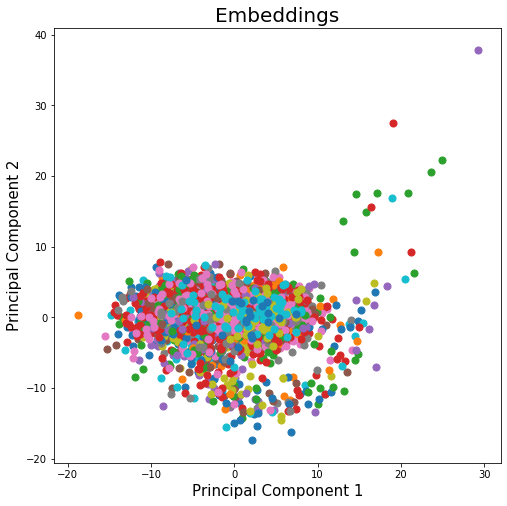

In [26]:
df = pd.DataFrame([tensor_row.detach().numpy() for tensor_row in model.emb_layers[0].weight])
map_to_county = pd.merge(merged_data[['State','state_county']],df,left_on=merged_data.index,right_on=df.index)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(map_to_county[map_to_county.columns[4:]])

map_to_county['comp1'] = principalComponents[:,0]
map_to_county['comp2'] = principalComponents[:,1]

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Embeddings', fontsize = 20)

for state in map_to_county['State'].unique():
    finalDf = map_to_county[map_to_county['State'] == state]
    ax.scatter(finalDf['comp1'],finalDf['comp2']
               #, c = color
               , s = 50)

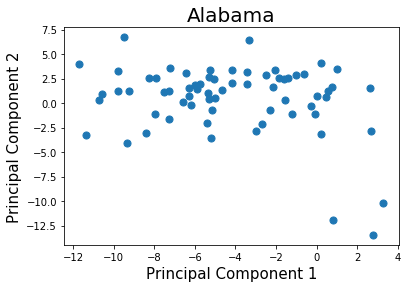

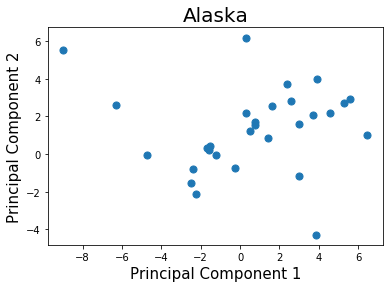

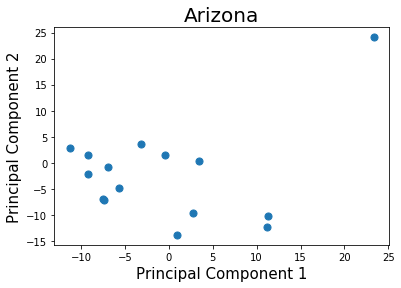

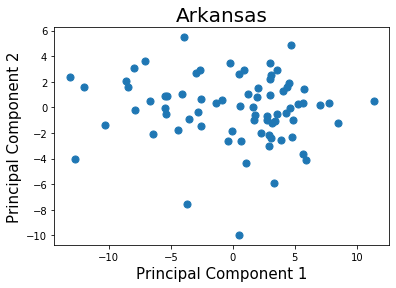

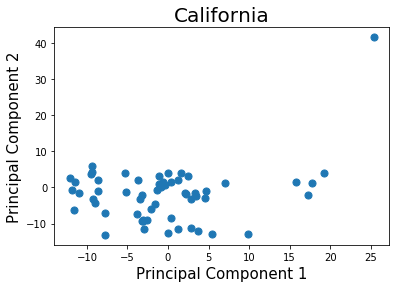

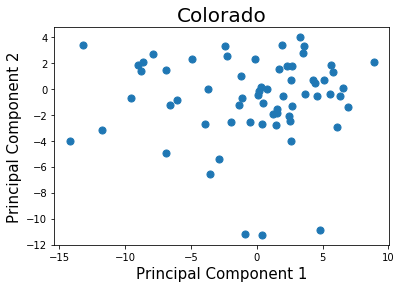

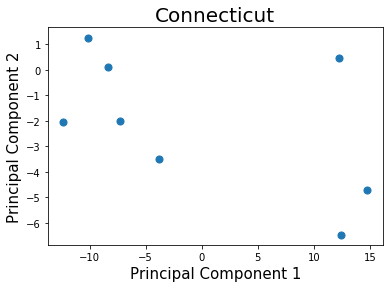

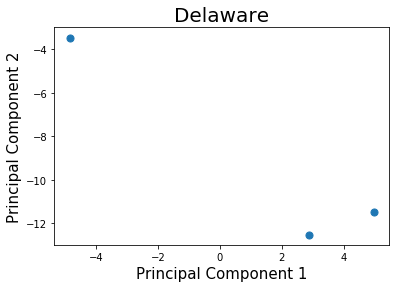

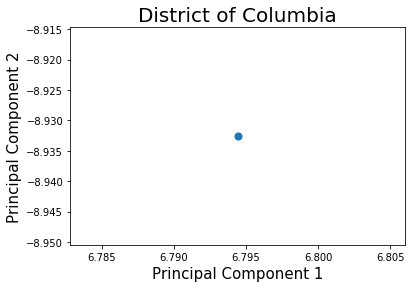

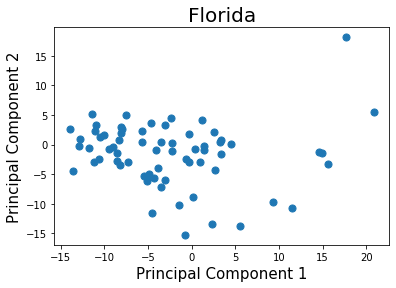

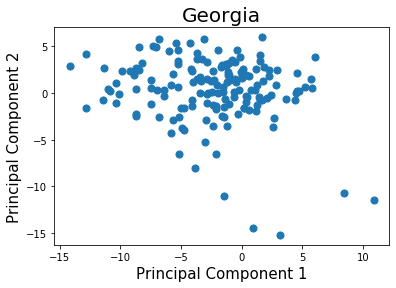

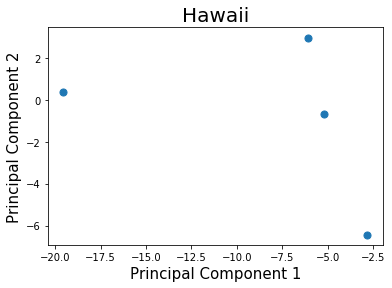

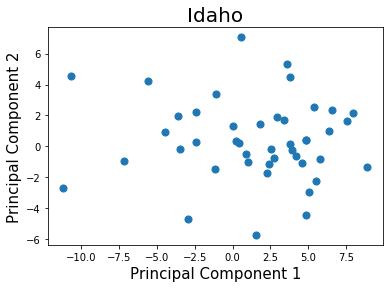

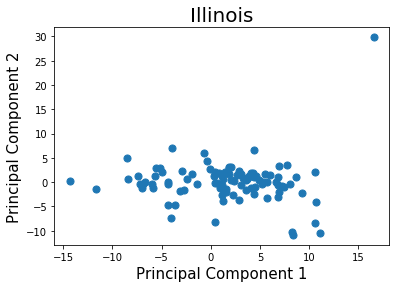

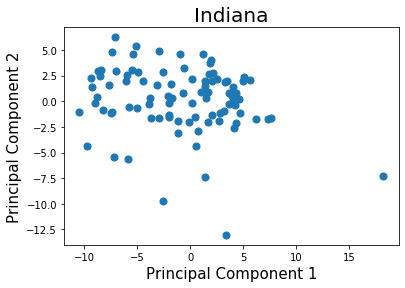

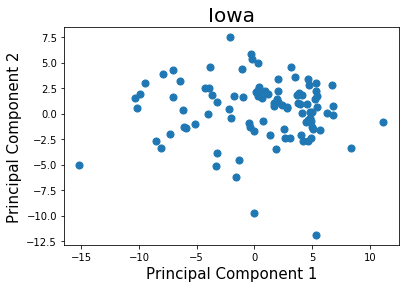

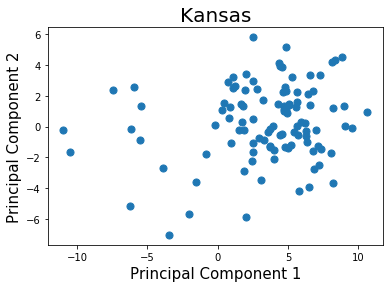

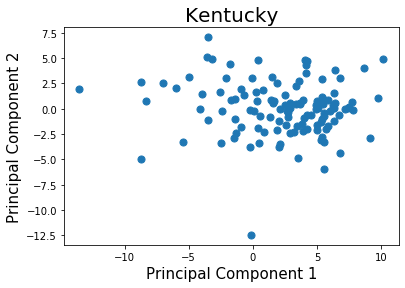

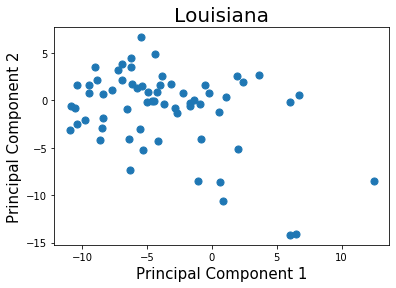

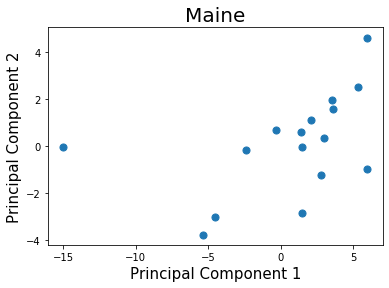

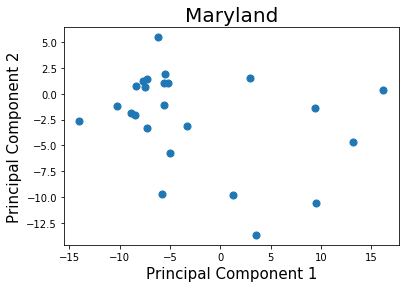

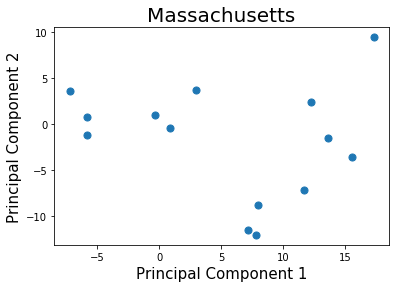

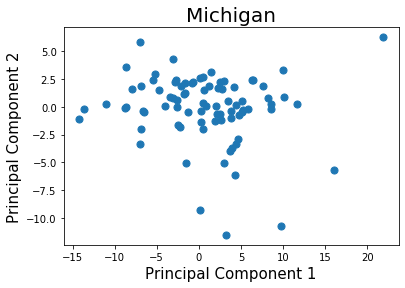

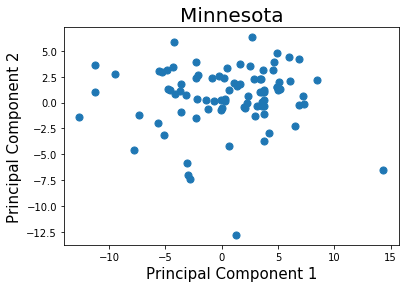

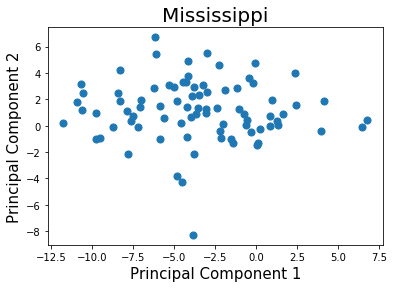

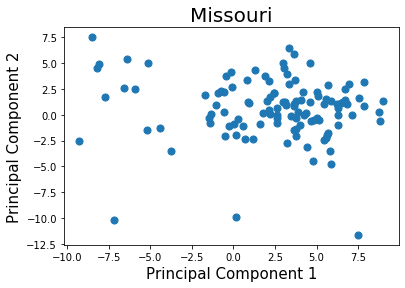

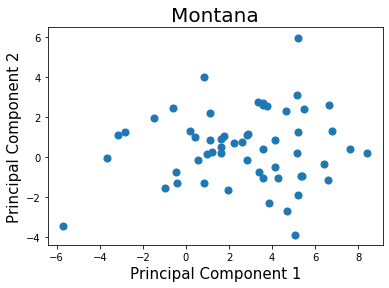

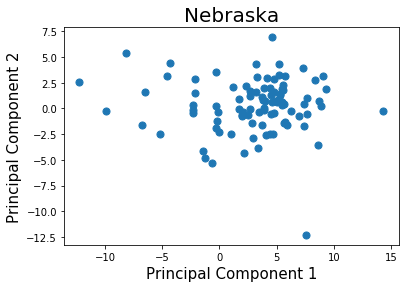

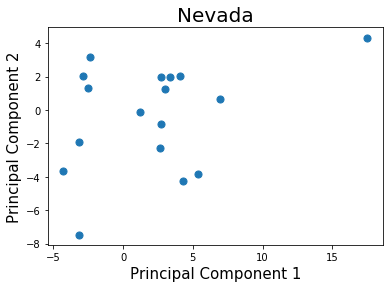

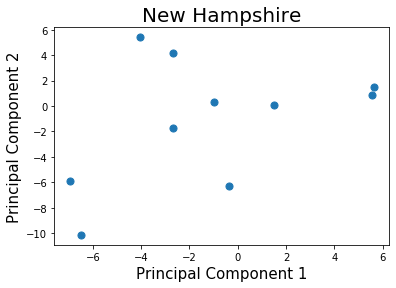

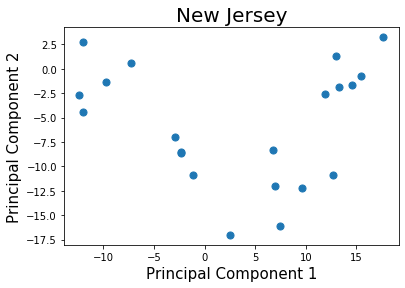

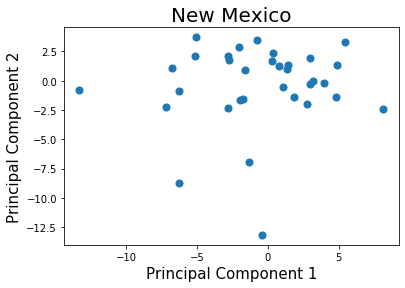

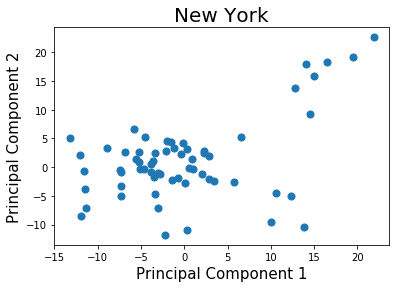

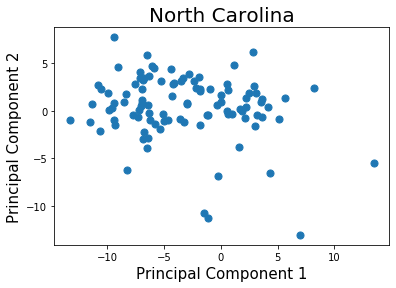

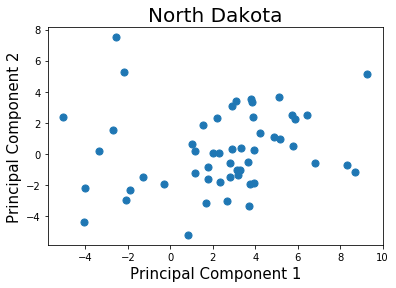

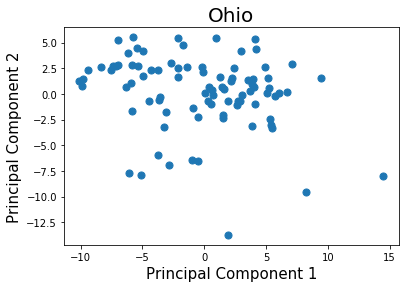

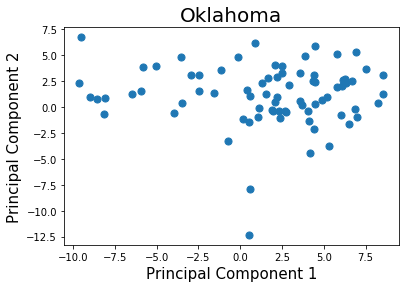

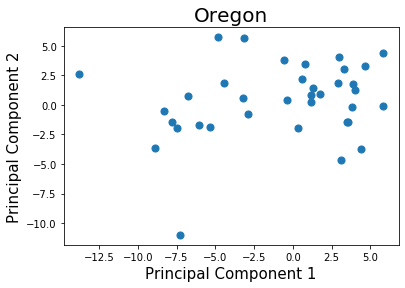

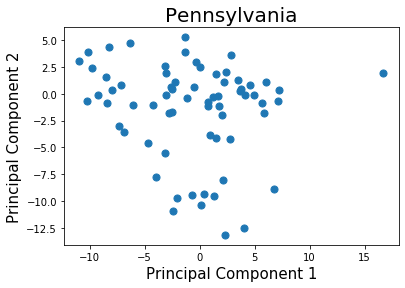

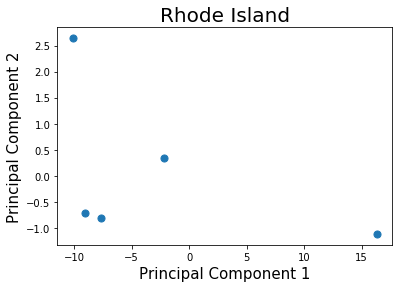

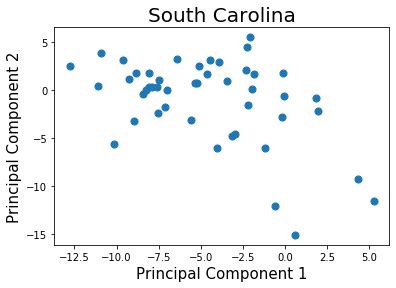

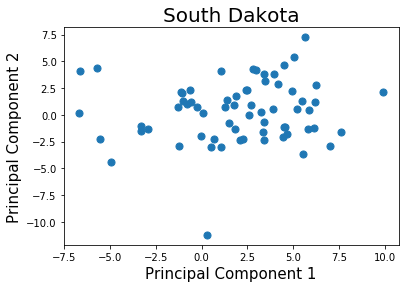

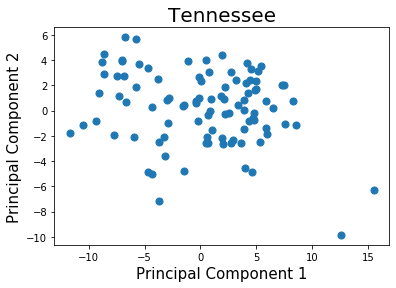

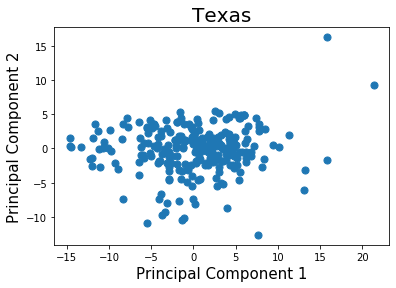

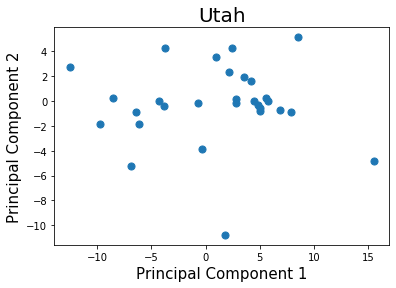

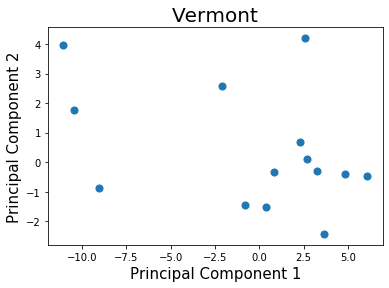

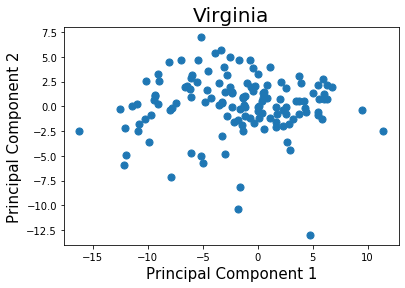

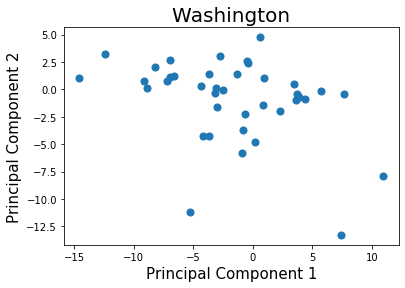

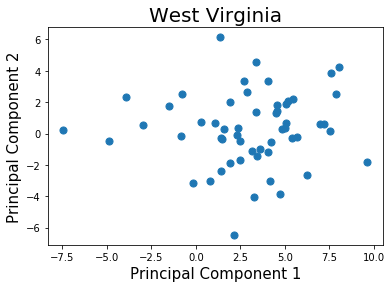

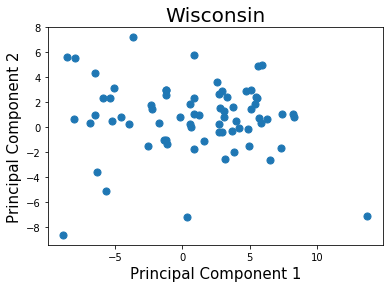

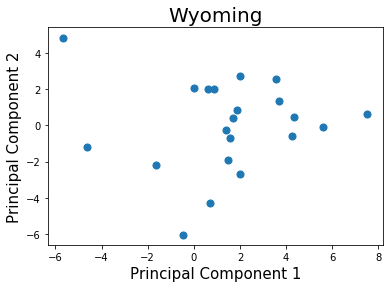

In [28]:
df = pd.DataFrame([tensor_row.detach().numpy() for tensor_row in model.emb_layers[0].weight])
map_to_county = pd.merge(merged_data[['State','County','state_county']],df,left_on=merged_data.index,right_on=df.index)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(map_to_county[map_to_county.columns[4:]])

map_to_county['comp1'] = principalComponents[:,0]
map_to_county['comp2'] = principalComponents[:,1]



for state in map_to_county['State'].unique():
    finalDf = map_to_county[map_to_county['State'] == state]
    
    plt.xlabel('Principal Component 1', fontsize = 15)
    plt.ylabel('Principal Component 2', fontsize = 15)
    plt.title(state, fontsize = 20)
    
    plt.scatter(finalDf['comp1'],finalDf['comp2']
               #, c = color
               , s = 50)
    plt.show()

In [29]:
#hidden layer
model.lin_layers[1].weight

Parameter containing:
tensor([[-0.1184, -0.2259, -1.3195,  ..., -0.2591,  0.1435,  0.6381],
        [-0.2761,  1.2644, -0.8769,  ..., -0.3000,  0.3389, -0.0155],
        [ 0.1147, -3.0106, -1.1563,  ...,  1.3417,  0.6801,  5.3589],
        ...,
        [ 5.3366, -1.3285,  3.0766,  ...,  0.4917,  1.3627, -0.6838],
        [ 0.8699,  0.0427, -0.9360,  ...,  0.7249,  0.2387,  0.9438],
        [-0.5871, -2.9185, -1.0789,  ...,  1.4756,  0.6678,  6.5836]],
       requires_grad=True)

# Cosine Similarity

In [30]:
def get_county_from_df(county, state, df):
    return df.query("County=='" + county + "' and State=='" +state+"'")

def get_most_similar_counties(target_embed, test_df, target_name):
    test_df = test_df.dropna()
    test_df[target_name] = test_df['embeddings'].map(lambda x: cosine_similarity(x.reshape(1,-1), target_embed.reshape(1,-1)))
    return test_df.sort_values(by=target_name)

map_to_county.drop(columns=['key_0'],inplace=True)

In [36]:
#cosine similarity
cosine_similarity(get_county_from_df("Aroostook", "Maine", map_to_county).values[0][3:].reshape(1,-1),
                  get_county_from_df("Broward", "Florida", map_to_county).values[0][3:].reshape(1,-1))

array([[-0.6454216]])

In [37]:
cosine_similarity(get_county_from_df("Aroostook", "Maine", map_to_county).values[0][3:].reshape(1,-1),
                  get_county_from_df("New York", "New York", map_to_county).values[0][3:].reshape(1,-1))

array([[0.61229036]])

In [38]:
cosine_similarity(get_county_from_df("Broward", "Florida", map_to_county).values[0][3:].reshape(1,-1),
                  get_county_from_df("New York", "New York", map_to_county).values[0][3:].reshape(1,-1))

array([[-0.71276188]])

In [50]:
embeddings_df = map_to_county[['State','County']]
embeddings_df['embeddings'] = [x for x in map_to_county[map_to_county.columns[3:]].values]
new_york_ny = get_county_from_df("New York", "New York", embeddings_df).values[0][2:][0]
get_most_similar_counties(new_york_ny, embeddings_df, "new_yor_sim")

,State,County,embeddings,new_yor_sim
2577,Texas,Dallam,"[-3.055492401123047, -2.596503973007202, -2.60...",[[-0.7618988960558988]]
1310,Michigan,Washtenaw,"[-3.9072277545928955, -2.1423587799072266, -4....",[[-0.7610904217839307]]
218,California,Riverside,"[-6.1943817138671875, -2.43005633354187, -4.69...",[[-0.7208591497539759]]
325,Florida,Broward,"[-3.726698160171509, -3.408400297164917, -4.84...",[[-0.7127618815552644]]
1223,Massachusetts,Hampshire,"[-1.594557285308838, -3.573867082595825, -4.42...",[[-0.708422702993649]]
...,...,...,...,...
1918,North Carolina,Davie,"[2.2258925437927246, 0.261083722114563, 4.0796...",[[0.7249779664459739]]
1792,New Jersey,Union,"[1.288535714149475, 3.456566572189331, 2.39507...",[[0.7270253871149058]]
1967,North Carolina,Rockingham,"[1.5527522563934326, 0.5316463708877563, 2.024...",[[0.735695519245868]]
250,Colorado,Boulder,"[2.0484955310821533, 1.5920203924179077, 5.096...",[[0.738613004158105]]
